0. Installing Dependencies

In [1]:
# Install whatever library you dont have
# !pip install textstat
# !pip install datasets

1. Importing Libraries

In [1]:
# import all needed libraries
import os
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional, Dropout, GlobalMaxPooling1D
from datasets import load_dataset
import random
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
from transformers import BertTokenizer, TFBertModel
from sklearn.model_selection import train_test_split
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import textstat
from nltk.tokenize import word_tokenize
from collections import Counter
from nltk import ngrams, pos_tag
import seaborn as sns

c:\Users\abura\miniconda3\envs\GP2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Dynamically allocating gpu resources
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

# Listing avalible GPU's
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

2. Preprocessing

In [3]:
# Load the datasets
generated_dataset = load_dataset("perlthoughts/big-brain-4k")
ivvy_dataset = load_dataset("qwedsacf/ivypanda-essays")
wikipedia_dataset = load_dataset("jordiclive/wikipedia-summary-dataset")

Repo card metadata block was not found. Setting CardData to empty.


In [5]:
# Reading the traning dataset
df = pd.read_csv("AI_Human.csv")
df

,text,generated
0,Cars. Cars have been around since they became ...,0.0
1,Transportation is a large necessity in most co...,0.0
2,"""America's love affair with it's vehicles seem...",0.0
3,How often do you ride in a car? Do you drive a...,0.0
4,Cars are a wonderful thing. They are perhaps o...,0.0
...,...,...
487230,Tie Face on Mars is really just a big misunder...,0.0
487231,The whole purpose of democracy is to create a ...,0.0
487232,I firmly believe that governments worldwide sh...,1.0
487233,I DFN't agree with this decision because a LFT...,0.0


In [6]:
# To see the distribution of the classes in the dataset
df['generated'].value_counts()

generated
0.0    305797
1.0    181438
Name: count, dtype: int64

In [7]:
# Separate the human-written and AI-generated essays
human_written = df[df['generated'] == 0.0]
ai_generated = df[df['generated'] == 1.0]

# Sample human-written essays to balance with the AI-generated essays
human_sampled = human_written.sample(n=180000, random_state=42)
ai_generated = ai_generated.sample(n=180000, random_state=42)

# Concatenate the sampled human-written essays with the AI-generated essays
df = pd.concat([human_sampled, ai_generated])

# Shuffle the combined data frame to mix the rows
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

print(df['generated'].value_counts())


generated
0.0    180000
1.0    180000
Name: count, dtype: int64


In [78]:
# Preprocessing phase for the data
# This is Testing phase 1 for this code.
# we are using new "batching techiuqe that yelids the batch using a function" to over come memory issues
# This code takes upto 4 minutes running to complete 100000 thousand records on my laptop
# working code till now

# It took 5min for 500 Thousand record

# Extract the 'output' column from the generated_dataset
generated_text = generated_dataset['train']['output']

# Extract the 'TEXT' column from the ivvy_dataset
human_text = ivvy_dataset['train']['TEXT']

# Extract the 'TEXT' column from the ivvy_dataset
# Shuffle the dataset and select a random subset of 100000 samples
wikipedia_sampled = wikipedia_dataset['train'].shuffle(seed=42).select(range(2500))
# Now you can extract the 'full_text' from the sampled subset


# Randomly sample from the generated text dataset to match the size of the human text dataset
generated_text_subset = random.sample(generated_text, 5000)
human_text_subset = random.sample(human_text, 2500)
wikipedia_text_subset = wikipedia_sampled['full_text'] # Its size was defined while randoming the sample

# Create a DataFrame for each type of text
generated_df = pd.DataFrame({'text': generated_text_subset, 'generated': 1})  # generated 1 indicates AI-generated text
human_df = pd.DataFrame({'text': human_text_subset, 'generated': 0})  # generated 0 indicates human-written text
wikipedia_df = pd.DataFrame({'text': wikipedia_text_subset, 'generated': 0}) # generated 0 indicates human-written text

# Concatenate the two DataFrames
df_test = pd.concat([generated_df, human_df, wikipedia_df], ignore_index=True)

# Shuffle the concatenated DataFrame to mix AI-generated and human-written texts
df_test = df_test.sample(frac=1).reset_index(drop=True)

# # Tokenize the entire dataset
# tokenizer = Tokenizer()
# tokenizer.fit_on_texts(df['text'])

# # Define batch size
# batch_size = 64


# def generate_batches(data, generateds, batch_size):
#   """
#   Generates batches of data and generateds.
#   """
#   for i in range(0, len(data), batch_size):
#     batch_texts = data[i:i + batch_size]
#     sequences = tokenizer.texts_to_sequences(batch_texts)
#     padded_sequences = pad_sequences(sequences, maxlen=max_len)  # Calculate max_len before padding
#     yield padded_sequences, generateds[i:i + batch_size]


# # Calculate maximum sequence length
# max_len = max([len(seq) for seq in tokenizer.texts_to_sequences(df['text'])])

# # Generate training batches using the generator function
# train_gen = generate_batches(df['text'], df['generated'], batch_size)

3. SENTIMENT (Feature number 1)

In [9]:
# This code takes 8.3 minutes running on 30000 records each class

#positive sentiment: compound score >= 0.05
#neutral sentiment: (compound score > -0.05) and (compound score < 0.05)
#negative sentiment: compound score <= -0.05

# Download VADER lexicon
nltk.download('vader_lexicon')

# # Load your dataset into a DataFrame (replace 'your_dataset.csv' with your actual dataset file)
# df = df

# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to get sentiment score for a given text
def get_sentiment_score(text):
    scores = analyzer.polarity_scores(text)
    return scores['compound']  # Compound score is a normalized score between -1 and 1

# Add a new column to store sentiment scores
df['sentiment_score'] = df['text'].apply(get_sentiment_score)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\abura\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [10]:
# These are the outputs of a 100000 thousand record from each generated
# Mean sentiment score for generated 0: 0.52937447
# Mean sentiment score for generated 1: 0.24948691299999998

# Assuming df is your DataFrame containing the data
# Replace df with the name of your DataFrame if it's different

# Group by the "generated" column and calculate the mean sentiment score for each group
mean_sentiment_by_generated = df.groupby('generated')['sentiment_score'].mean()

# Display the mean sentiment scores for each generated
print("Mean sentiment score for generated 0:", mean_sentiment_by_generated[0])
print("Mean sentiment score for generated 1:", mean_sentiment_by_generated[1])

Mean sentiment score for generated 0: 0.6046176427777779
Mean sentiment score for generated 1: 0.8618623538888889


In [11]:
# This code adjust your DataFrame such that each sentiment score is in its own column and contains a categorical value based on the highest score (negative, neutral, positive)
# Dr. omar recomended this

# import numpy as np
# import pandas as pd
# from nltk.sentiment import SentimentIntensityAnalyzer
# import nltk
# nltk.download('vader_lexicon')

# # Assuming df is your DataFrame and it has a column 'text' which contains the text data

# # Initialize VADER sentiment analyzer
# analyzer = SentimentIntensityAnalyzer()

# # Function to categorize sentiment score
# def categorize_sentiment(scores):
#     max_generated, max_score = max(scores.items(), key=lambda item: item[1])
#     categories = {'neg': 1, 'neu': 2, 'pos': 3}
#     return categories[max_generated]

# # Function to get sentiment score for a given text
# def get_sentiment_score(text):
#     scores = analyzer.polarity_scores(text)
#     category = categorize_sentiment(scores)
#     return category

# # Add a new column to store sentiment category
# df['sentiment_category'] = df['text'].apply(get_sentiment_score)

4. POS TAGGING (Feature number 2)

In [12]:
# this code is for part-of-speech (POS) tagging
# 40 Thousand records took 13 minutes on my laptop

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

# Function to perform POS tagging on text
def pos_tagging(text):
    tokens = word_tokenize(text)
    pos_tags = pos_tag(tokens)
    return pos_tags

# Add a new column for POS tags
df['pos_tags'] = df['text'].apply(pos_tagging)

# Function to extract POS tag frequencies from a list of POS tags
def count_pos_tags(pos_tags):
    pos_tag_freq = Counter(tag for _, tag in pos_tags)  # Extract POS tag counts directly from tuples
    return dict(pos_tag_freq)

# Calculate POS tag frequencies for each sample
df['pos_tag_freq'] = df['pos_tags'].apply(count_pos_tags)

# Convert POS tag frequencies into separate columns
pos_tags_df = pd.DataFrame(df['pos_tag_freq'].tolist()).fillna(0)

# Concatenate the POS tag features with the original dataset
df = pd.concat([df, pos_tags_df], axis=1)

# Now your DataFrame df includes separate columns for each POS tag count
df.head()


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\abura\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\abura\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


,text,generated,sentiment_score,pos_tags,pos_tag_freq,NN,VBZ,DT,NNP,JJS,...,RBS,:,(,),#,FW,WP$,$,SYM,LS
0,Pollution is a pestering problem worldwide AKD...,0.0,0.9818,"[(Pollution, NN), (is, VBZ), (a, DT), (pesteri...","{'NN': 81, 'VBZ': 23, 'DT': 36, 'NNP': 23, 'JJ...",81.0,23.0,36.0,23.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"""All of our development since World War II was...",0.0,0.9510,"[(``, ``), (All, DT), (of, IN), (our, PRP$), (...","{'``': 3, 'DT': 65, 'IN': 63, 'PRP$': 6, 'NN':...",110.0,20.0,65.0,41.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"Deer Senator,\n\nI write to you About L pressi...",1.0,0.9866,"[(Deer, NNP), (Senator, NNP), (,, ,), (I, PRP)...","{'NNP': 75, ',': 30, 'PRP': 12, 'VBP': 10, 'TO...",86.0,18.0,59.0,75.0,2.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,While distance learning offers flexibility and...,1.0,0.9733,"[(While, IN), (distance, NN), (learning, VBG),...","{'IN': 36, 'NN': 44, 'VBG': 12, 'NNS': 40, 'CC...",44.0,3.0,13.0,6.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Title: The Future of Transportation: Driverles...,1.0,0.9971,"[(Title, NN), (:, :), (The, DT), (Future, NN),...","{'NN': 84, ':': 10, 'DT': 38, 'IN': 45, 'NNPS'...",84.0,4.0,38.0,5.0,1.0,...,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


4. READABILITY (Feature number 3)

In [13]:
# This code gives us all the needed redability metrics

# SMOG Index (Simple Measure of Gobbledygook):
# The SMOG Index estimates the years of education required to understand a text based on the number of polysyllabic words in the text.
# It is particularly useful for longer texts and academic writing.
# Gunning Fog Index:
# The Gunning Fog Index estimates the years of formal education needed to understand a text.
# It considers the average sentence length and the percentage of complex words (words with three or more syllables) in the text.



# Function to calculate readability metrics
def calculate_readability(text):
    # Flesch Reading Ease (higher score indicates easier readability)
    flesch_reading_ease = textstat.flesch_reading_ease(text)
    
    # Flesch-Kincaid Grade Level (lower grade level indicates easier readability)
    flesch_kincaid_grade = textstat.flesch_kincaid_grade(text)
    
    # Automated Readability Index (higher score indicates easier readability)
    automated_readability_index = textstat.automated_readability_index(text)
    
    # Coleman-Liau Index (lower index indicates easier readability)
    coleman_liau_index = textstat.coleman_liau_index(text)
    
    # SMOG Index (higher index indicates more difficult readability)
    smog_index = textstat.smog_index(text)
    
    # Gunning Fog Index (lower index indicates easier readability)
    gunning_fog = textstat.gunning_fog(text)
    
    return {
        'flesch_reading_ease': flesch_reading_ease,  # Higher score indicates easier readability
        'flesch_kincaid_grade': flesch_kincaid_grade,  # Lower grade level indicates easier readability
        'automated_readability_index': automated_readability_index,  # Higher score indicates easier readability
        'coleman_liau_index': coleman_liau_index,  # Lower index indicates easier readability
        'smog_index': smog_index,  # Higher index indicates more difficult readability
        'gunning_fog': gunning_fog  # Lower index indicates easier readability
    }

# Apply the function to calculate readability metrics for each text
df['readability_metrics'] = df['text'].apply(calculate_readability)

In [14]:
# Extract readability metrics into separate columns
df['flesch_reading_ease'] = df['readability_metrics'].apply(lambda x: x['flesch_reading_ease'])
df['flesch_kincaid_grade'] = df['readability_metrics'].apply(lambda x: x['flesch_kincaid_grade'])
df['automated_readability_index'] = df['readability_metrics'].apply(lambda x: x['automated_readability_index'])
df['coleman_liau_index'] = df['readability_metrics'].apply(lambda x: x['coleman_liau_index'])
df['smog_index'] = df['readability_metrics'].apply(lambda x: x['smog_index'])
df['gunning_fog'] = df['readability_metrics'].apply(lambda x: x['gunning_fog'])

# Drop the 'readability_metrics' column as it's no longer needed
# df.drop(columns=['readability_metrics'], inplace=True)

In [15]:
# Calculate mean readability scores for each class
mean_scores_class_0 = df[df['generated'] == 0][['flesch_reading_ease', 'flesch_kincaid_grade', 'automated_readability_index', 'coleman_liau_index', 'smog_index', 'gunning_fog']].mean()
mean_scores_class_1 = df[df['generated'] == 1][['flesch_reading_ease', 'flesch_kincaid_grade', 'automated_readability_index', 'coleman_liau_index', 'smog_index', 'gunning_fog']].mean()

# Print mean readability scores for each class
print("Mean readability scores for Class 0:")
print(mean_scores_class_0)
print("\nMean readability scores for Class 1:")
print(mean_scores_class_1)


Mean readability scores for Class 0:
flesch_reading_ease            69.086627
flesch_kincaid_grade            9.013464
automated_readability_index    10.794149
coleman_liau_index              8.320263
smog_index                     10.217486
gunning_fog                    10.511115
dtype: float64

Mean readability scores for Class 1:
flesch_reading_ease            53.783559
flesch_kincaid_grade           10.557558
automated_readability_index    12.404594
coleman_liau_index             11.577479
smog_index                     12.803774
gunning_fog                    11.515895
dtype: float64


In [16]:
# Scores were measured on a sample of 20 Thousand records
# From this output we can say that our hypothisis is valid (AI Text Is Easier To be Readed).

# Mean readability scores for Class 0:
# flesch_reading_ease            38.827490 ||   Higher means EASIER to read
# flesch_kincaid_grade           12.461640 ||   Higher means harder to read
# automated_readability_index    15.623130 ||   Higher means harder to read
# coleman_liau_index             14.710449 ||   Higher means harder to read
# smog_index                     11.891800 ||   Higher means harder to read
# gunning_fog                    12.272332 ||   Higher means harder to read
# dtype: float64

# Mean readability scores for Class 1:
# flesch_reading_ease            63.794366 ||   Lower means HARDER to read
# flesch_kincaid_grade            8.679610 ||   Lower means easier to read
# automated_readability_index    10.847720 ||   Lower means easier to read
# coleman_liau_index              8.119910 ||   Lower means easier to read
# smog_index                      6.760170 ||   Lower means easier to read
# gunning_fog                    10.580816 ||   Lower means easier to read

In [17]:
df

,text,generated,sentiment_score,pos_tags,pos_tag_freq,NN,VBZ,DT,NNP,JJS,...,$,SYM,LS,readability_metrics,flesch_reading_ease,flesch_kincaid_grade,automated_readability_index,coleman_liau_index,smog_index,gunning_fog
0,Pollution is a pestering problem worldwide AKD...,0.0,0.9818,"[(Pollution, NN), (is, VBZ), (a, DT), (pesteri...","{'NN': 81, 'VBZ': 23, 'DT': 36, 'NNP': 23, 'JJ...",81.0,23.0,36.0,23.0,3.0,...,0.0,0.0,0.0,"{'flesch_reading_ease': 49.28, 'flesch_kincaid...",49.28,13.9,17.0,11.73,14.6,15.51
1,"""All of our development since World War II was...",0.0,0.9510,"[(``, ``), (All, DT), (of, IN), (our, PRP$), (...","{'``': 3, 'DT': 65, 'IN': 63, 'PRP$': 6, 'NN':...",110.0,20.0,65.0,41.0,0.0,...,0.0,0.0,0.0,"{'flesch_reading_ease': 63.19, 'flesch_kincaid...",63.19,8.5,9.8,9.97,10.9,9.15
2,"Deer Senator,\n\nI write to you About L pressi...",1.0,0.9866,"[(Deer, NNP), (Senator, NNP), (,, ,), (I, PRP)...","{'NNP': 75, ',': 30, 'PRP': 12, 'VBP': 10, 'TO...",86.0,18.0,59.0,75.0,2.0,...,0.0,0.0,0.0,"{'flesch_reading_ease': 51.48, 'flesch_kincaid...",51.48,11.0,13.7,13.11,13.3,12.51
3,While distance learning offers flexibility and...,1.0,0.9733,"[(While, IN), (distance, NN), (learning, VBG),...","{'IN': 36, 'NN': 44, 'VBG': 12, 'NNS': 40, 'CC...",44.0,3.0,13.0,6.0,0.0,...,0.0,0.0,0.0,"{'flesch_reading_ease': 39.13, 'flesch_kincaid...",39.13,11.6,14.2,16.00,13.2,12.13
4,Title: The Future of Transportation: Driverles...,1.0,0.9971,"[(Title, NN), (:, :), (The, DT), (Future, NN),...","{'NN': 84, ':': 10, 'DT': 38, 'IN': 45, 'NNPS'...",84.0,4.0,38.0,5.0,1.0,...,0.0,0.0,0.0,"{'flesch_reading_ease': 21.02, 'flesch_kincaid...",21.02,16.5,19.6,17.35,18.1,16.62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359995,"Seagoing Cowboys\n\nImagine being on a boat, o...",0.0,0.9923,"[(Seagoing, VBG), (Cowboys, NNP), (Imagine, NN...","{'VBG': 7, 'NNP': 19, 'IN': 18, 'DT': 24, 'NN'...",23.0,5.0,24.0,19.0,0.0,...,0.0,0.0,0.0,"{'flesch_reading_ease': 69.48, 'flesch_kincaid...",69.48,6.1,5.9,7.57,8.7,5.56
359996,"Dear Senator,\n\nI am writing to you today to ...",1.0,0.9826,"[(Dear, NNP), (Senator, NNP), (,, ,), (I, PRP)...","{'NNP': 20, ',': 8, 'PRP': 9, 'VBP': 7, 'VBG':...",34.0,14.0,37.0,20.0,1.0,...,0.0,0.0,0.0,"{'flesch_reading_ease': 63.59, 'flesch_kincaid...",63.59,8.4,9.8,10.38,10.5,9.65
359997,This article is about the patent of Venus that...,0.0,0.9493,"[(This, DT), (article, NN), (is, VBZ), (about,...","{'DT': 50, 'NN': 60, 'VBZ': 18, 'IN': 46, 'NNP...",60.0,18.0,50.0,18.0,3.0,...,0.0,0.0,0.0,"{'flesch_reading_ease': 42.42, 'flesch_kincaid...",42.42,18.6,23.1,10.23,14.2,20.66
359998,"To whom it may concern,\n\nIn my own opinion I...",0.0,0.9896,"[(To, TO), (whom, WP), (it, PRP), (may, MD), (...","{'TO': 15, 'WP': 6, 'PRP': 21, 'MD': 16, 'NN':...",44.0,17.0,53.0,36.0,2.0,...,0.0,0.0,0.0,"{'flesch_reading_ease': 65.05, 'flesch_kincaid...",65.05,9.9,12.3,9.52,11.7,11.63


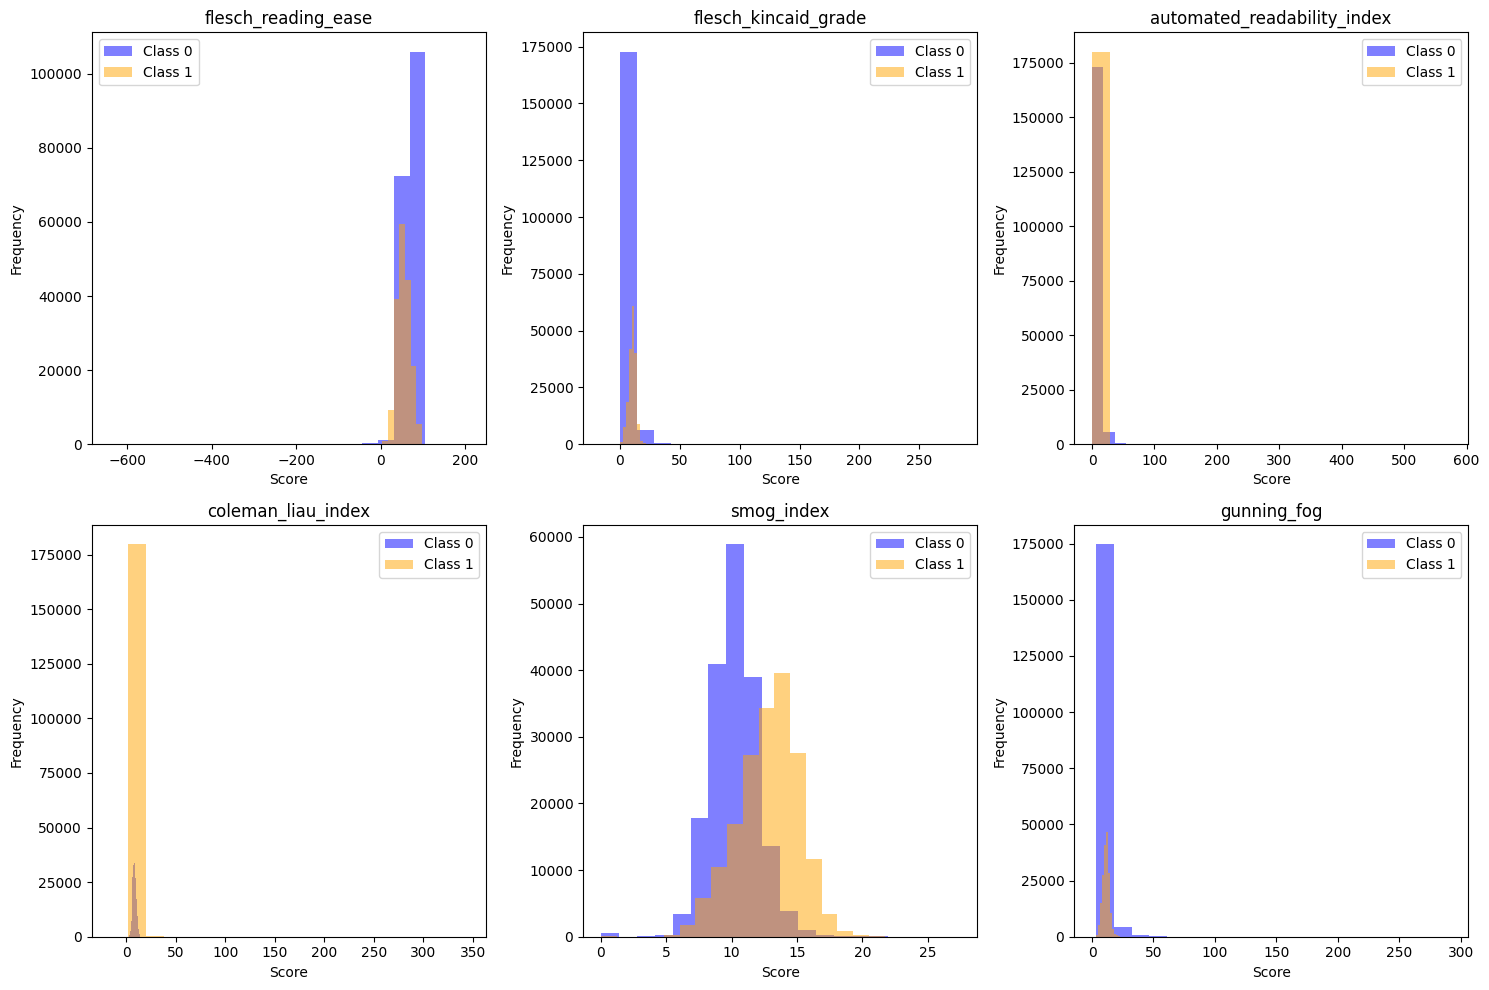

In [18]:
import matplotlib.pyplot as plt

# Create subplots for each readability metric
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

# Iterate over each readability metric and plot histograms for each class
for i, metric in enumerate(['flesch_reading_ease', 'flesch_kincaid_grade', 'automated_readability_index', 'coleman_liau_index', 'smog_index', 'gunning_fog']):
    row_index = i // 3
    col_index = i % 3
    ax = axes[row_index, col_index]
    
    # Plot histograms for each class
    ax.hist(df[df['generated'] == 0][metric], bins=20, alpha=0.5, color='blue', label='Class 0')
    ax.hist(df[df['generated'] == 1][metric], bins=20, alpha=0.5, color='orange', label='Class 1')
    
    # Set titles and labels
    ax.set_title(metric)
    ax.set_xlabel('Score')
    ax.set_ylabel('Frequency')
    ax.legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


In [19]:
# Calculate the mean and standard deviation of each readability metric for each class
for metric in df['readability_metrics'].iloc[0].keys():
    mean_class_0 = df[df['generated'] == 0]['readability_metrics'].apply(lambda x: x[metric]).mean()
    mean_class_1 = df[df['generated'] == 1]['readability_metrics'].apply(lambda x: x[metric]).mean()
    
    std_class_0 = df[df['generated'] == 0]['readability_metrics'].apply(lambda x: x[metric]).std()
    std_class_1 = df[df['generated'] == 1]['readability_metrics'].apply(lambda x: x[metric]).std()
    
    print("Readability Metric:", metric)
    print("Mean (Class 0):", mean_class_0)
    print("Mean (Class 1):", mean_class_1)
    print("Standard Deviation (Class 0):", std_class_0)
    print("Standard Deviation (Class 1):", std_class_1)
    print()


# Readability Metric: flesch_reading_ease
# Mean (Class 0): 38.832343
# Mean (Class 1): 64.05096150000001
# Standard Deviation (Class 0): 29.929642878031327
# Standard Deviation (Class 1): 27.73158427387146

# Readability Metric: flesch_kincaid_grade
# Mean (Class 0): 12.480405
# Mean (Class 1): 8.646920000000001
# Standard Deviation (Class 0): 5.151190180335871
# Standard Deviation (Class 1): 5.219818563790502

# Readability Metric: automated_readability_index
# Mean (Class 0): 15.660995000000002
# Mean (Class 1): 10.797925
# Standard Deviation (Class 0): 6.905278289351391
# Standard Deviation (Class 1): 8.338594833817334

# Readability Metric: coleman_liau_index
# Mean (Class 0): 14.710249
# Mean (Class 1): 8.145714499999999
# Standard Deviation (Class 0): 5.337369350492636
# Standard Deviation (Class 1): 9.0150204685953

# Readability Metric: smog_index
# Mean (Class 0): 11.959380000000001
# Mean (Class 1): 6.750789999999999
# Standard Deviation (Class 0): 4.928420384055534
# Standard Deviation (Class 1): 5.8409849538550915

# Readability Metric: gunning_fog
# Mean (Class 0): 12.2736345
# Mean (Class 1): 10.5480175
# Standard Deviation (Class 0): 4.787573972132095
# Standard Deviation (Class 1): 5.443355265874282

Readability Metric: flesch_reading_ease
Mean (Class 0): 69.08662705555557
Mean (Class 1): 53.783559000000004
Standard Deviation (Class 0): 16.56001611087143
Standard Deviation (Class 1): 15.706731403736994

Readability Metric: flesch_kincaid_grade
Mean (Class 0): 9.013463888888888
Mean (Class 1): 10.557558333333333
Standard Deviation (Class 0): 5.827935085570684
Standard Deviation (Class 1): 2.8405019170509687

Readability Metric: automated_readability_index
Mean (Class 0): 10.794148888888891
Mean (Class 1): 12.404594444444445
Standard Deviation (Class 0): 7.413691515789354
Standard Deviation (Class 1): 3.7244103423128467

Readability Metric: coleman_liau_index
Mean (Class 0): 8.320262944444442
Mean (Class 1): 11.577479055555553
Standard Deviation (Class 0): 1.8074249568559229
Standard Deviation (Class 1): 3.247335103294797

Readability Metric: smog_index
Mean (Class 0): 10.217485555555557
Mean (Class 1): 12.803773888888887
Standard Deviation (Class 0): 1.8590798233717583
Standard Devi

6. REPETITIVENESS (Feature number 4)

In [20]:
def ngram_repetitiveness(text, n=2):
    words = text.split()
    n_grams = list(ngrams(words, n))
    ngram_counts = Counter(n_grams)
    repeats = {ngram: count for ngram, count in ngram_counts.items() if count > 1}
    repetitiveness_score = sum(repeats.values()) / len(n_grams) if n_grams else 0
    return repetitiveness_score

# Apply n-gram repetitiveness calculation for bigrams
df['bigram_repetitiveness'] = df['text'].apply(lambda x: ngram_repetitiveness(x, 2))


In [21]:
# Calculate mean repetitiveness score for each generated
mean_repetitiveness = df.groupby('generated')['bigram_repetitiveness'].mean()

print(mean_repetitiveness)

generated
0.0    0.211014
1.0    0.260687
Name: bigram_repetitiveness, dtype: float64


In [22]:
def pos_repetitiveness(pos_tags):
    tag_sequences = [tag for _, tag in pos_tags]
    tag_counts = Counter(tag_sequences)
    repeats = {tag: count for tag, count in tag_counts.items() if count > 1}
    repetitiveness_score = sum(repeats.values()) / len(tag_sequences) if tag_sequences else 0
    return repetitiveness_score

# Apply POS structural repetitiveness calculation
df['pos_repetitiveness'] = df['pos_tags'].apply(pos_repetitiveness)


In [23]:
# Calculate mean repetitiveness score for each generated
mean_repetitiveness_pos = df.groupby('generated')['pos_repetitiveness'].mean()

print(mean_repetitiveness_pos)

generated
0.0    0.989371
1.0    0.988281
Name: pos_repetitiveness, dtype: float64


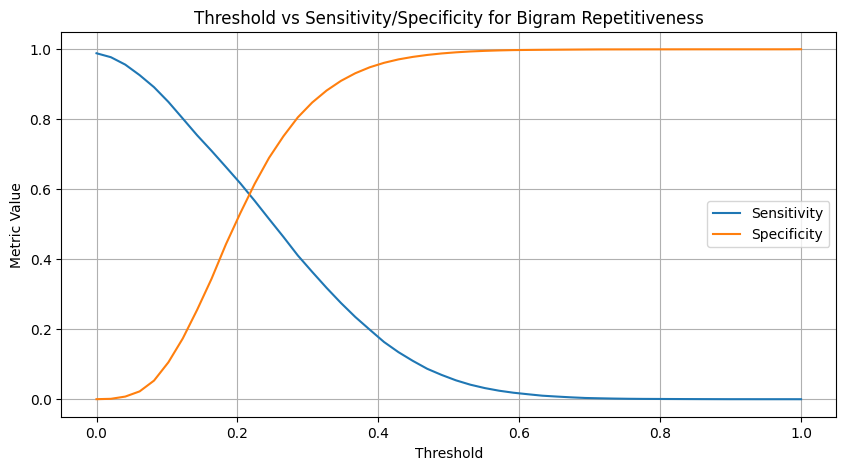

In [24]:
# Function to calculate sensitivity and specificity
def calculate_metrics(data, threshold):
    data['pred_generated'] = (data['bigram_repetitiveness'] > threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(data['generated'], data['pred_generated']).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    return sensitivity, specificity

# Set thresholds to test
thresholds = np.linspace(min(df['bigram_repetitiveness']), max(df['bigram_repetitiveness']), num=50)
sensitivities = []
specificities = []

# Calculate metrics for each threshold
for threshold in thresholds:
    sensitivity, specificity = calculate_metrics(df.copy(), threshold)
    sensitivities.append(sensitivity)
    specificities.append(specificity)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(thresholds, sensitivities, label='Sensitivity')
plt.plot(thresholds, specificities, label='Specificity')
plt.title('Threshold vs Sensitivity/Specificity for Bigram Repetitiveness')
plt.xlabel('Threshold')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(True)
plt.show()


Save/Read CHECK POINT 1 (Saving The DataFrame)

In [25]:
# Save the updated DataFrame That contains the 4 features with no BERT Embeddings yet, to a new CSV file
df.to_csv('Full_Featuers_DataSet_360thousand_AI_Human.csv', index=False, escapechar='\\')

In [12]:
# Reading the updated DataFrame
df = pd.read_csv('Full_Featuers_DataSet_360thousand_AI_Human.csv')

7. BERT EMBEDDING (Main Feature. Number 5)

In [27]:
# import pandas as pd

# random_records = df.sample(n=100000)
# df = random_records

In [28]:
# import pandas as pd

# # Assuming df is your DataFrame and 'generated' is the column containing generateds

# # Split the DataFrame into two separate DataFrames based on the class generated
# class_0_df = df[df['generated'] == 0]
# class_1_df = df[df['generated'] == 1]

# # Sample 50,000 records from each class
# sample_class_0 = class_0_df.sample(n=50000, replace=True)  # Use replace=True to allow sampling with replacement
# sample_class_1 = class_1_df.sample(n=50000, replace=True)

# # Concatenate the sampled DataFrames to create the final DataFrame with 100,000 records
# random_records = pd.concat([sample_class_0, sample_class_1])

# # Reset index if needed
# random_records.reset_index(drop=True, inplace=True)

# # This will give you a DataFrame with 50,000 records from class 0 and 50,000 records from class 1


In [29]:
# This code takes 100 minutes running on 60000 records each class
# Getting Bert Embeddings for the text.

# Load BERT tokenizer and model
print("Loading BERT tokenizer and model...")
bert_model = TFBertModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

print("Tokenizing input text...")
input_text = df['text'].tolist()
# Convert non-string elements to strings before slicing
input_text = [str(text)[:512] if not isinstance(text, str) else text[:512] for text in input_text]
# Limit sequence length to 512 tokens
input_ids = tokenizer(input_text, padding=True, truncation=True, return_tensors="tf")["input_ids"]

# Get BERT embeddings
print("Getting BERT embeddings...")

# Define batch size
batch_size = 32 #350 crashed when the size of the data was 100000 Thousands.

# Get the number of samples
num_samples = len(input_ids)

# Initialize an empty list to store pooled outputs
pooled_outputs_list = []

# Process inputs in batches
for i in range(0, num_samples, batch_size):
    batch_input_ids = input_ids[i:i+batch_size]
    batch_outputs = bert_model(batch_input_ids)
    batch_pooled_output = batch_outputs.pooler_output
    pooled_outputs_list.append(batch_pooled_output)

# Concatenate pooled outputs from all batches
pooled_output = tf.concat(pooled_outputs_list, axis=0)

# Convert pooled_output to numpy array
print("Converting pooled_output to numpy array...")
pooled_output_array = np.array(pooled_output)

Loading BERT tokenizer and model...


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Tokenizing input text...
Getting BERT embeddings...
Converting pooled_output to numpy array...


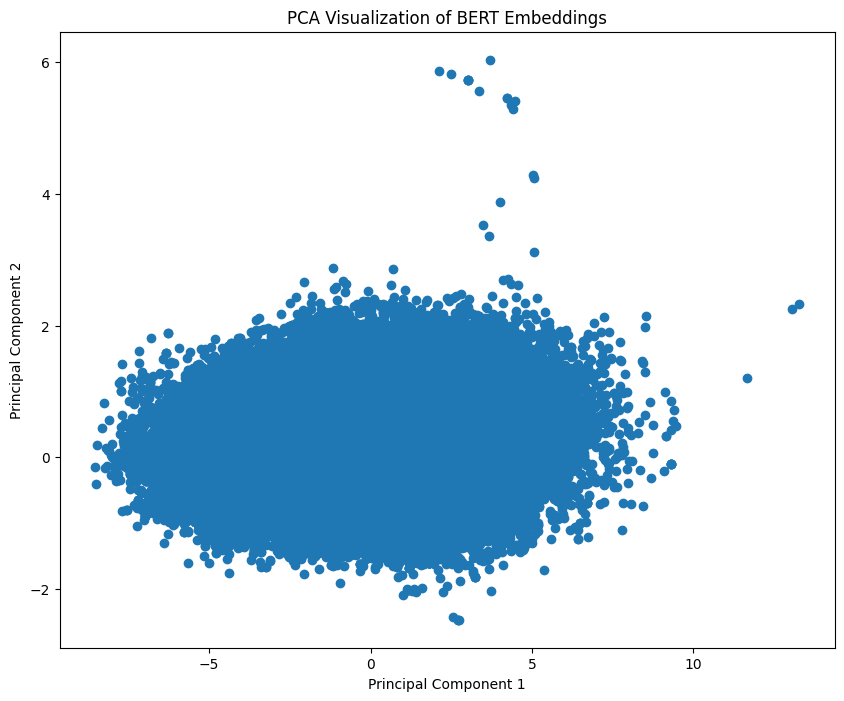

In [30]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Perform PCA to reduce dimensionality
pca = PCA(n_components=2)
pooled_output_pca = pca.fit_transform(pooled_output_array)

# Plot the PCA-transformed embeddings
plt.figure(figsize=(10, 8))
plt.scatter(pooled_output_pca[:, 0], pooled_output_pca[:, 1])
plt.title('PCA Visualization of BERT Embeddings')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


In [2]:
# Load the saved BERT embeddings
bert_embeddings_AI_Human = np.load("bert_embeddings_360thousand_Full_Featuers_DataSet_360thousand.npy")
bert_embeddings_Huggning = np.load("bert_embeddings_500thousand_Full_Featuers_DataSet_500thousand.npy")

In [3]:
bert_embeddings_AI_Human = np.load("bert_embeddings_360thousand_Full_Featuers_DataSet_360thousand.npy")
bert_embeddings_Hugging = np.load("bert_embeddings_500thousand_Full_Featuers_DataSet_500thousand.npy")

print(bert_embeddings_AI_Human.shape)  # Should be (360000, 768)
print(bert_embeddings_Hugging.shape)   # Should be (500000, 768)

(360000, 768)
(500000, 768)


In [4]:
print(np.isnan(bert_embeddings_AI_Human).sum())  # Should be 0
print(np.isnan(bert_embeddings_Hugging).sum())   # Should be 0

print(np.isinf(bert_embeddings_AI_Human).sum())  # Should be 0
print(np.isinf(bert_embeddings_Hugging).sum())   # Should be 0

0
0
0
0


In [5]:
combined_embeddings = np.concatenate((bert_embeddings_AI_Human, bert_embeddings_Hugging), axis=0)
print(combined_embeddings.shape)  # Should be (860000, 768)

(860000, 768)


In [6]:
!pip install openTSNE

   ---------------------------------------- 0.0/462.1 kB ? eta -:--:--
   ---------------------------------------- 0.0/462.1 kB ? eta -:--:--
    --------------------------------------- 10.2/462.1 kB ? eta -:--:--
    --------------------------------------- 10.2/462.1 kB ? eta -:--:--
   --- ----------------------------------- 41.0/462.1 kB 281.8 kB/s eta 0:00:02
   ------- ------------------------------- 92.2/462.1 kB 525.1 kB/s eta 0:00:01
   ----------- -------------------------- 143.4/462.1 kB 708.1 kB/s eta 0:00:01
   ------------------------------- -------- 358.4/462.1 kB 1.4 MB/s eta 0:00:01
   ---------------------------------------- 462.1/462.1 kB 1.5 MB/s eta 0:00:00


In [ ]:
# conda install -c rapidsai -c nvidia -c conda-forge cuml=21.12 python=3.8 cudatoolkit=11.0


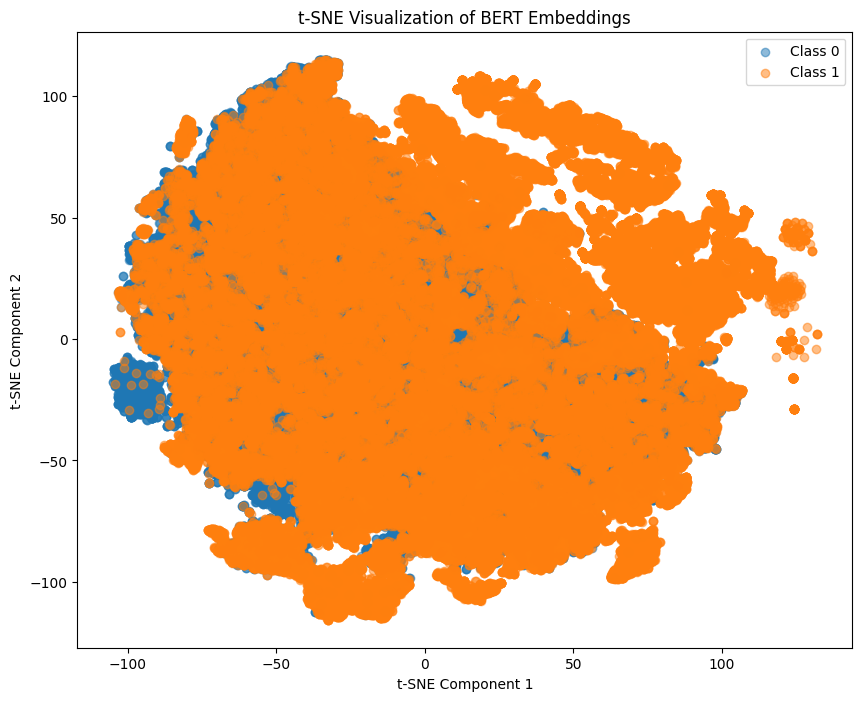

In [1]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Load embeddings
bert_embeddings_AI_Human = np.load("bert_embeddings_360thousand_Full_Featuers_DataSet_360thousand.npy")
bert_embeddings_Huggning = np.load("bert_embeddings_500thousand_Full_Featuers_DataSet_500thousand.npy")

# Number of samples to take from each set
num_samples = 100000

# Randomly sample from each set
random_indices_AI_Human = np.random.choice(bert_embeddings_AI_Human.shape[0], num_samples, replace=False)
random_indices_Huggning = np.random.choice(bert_embeddings_Huggning.shape[0], num_samples, replace=False)

sampled_embeddings_AI_Human = bert_embeddings_AI_Human[random_indices_AI_Human]
sampled_embeddings_Huggning = bert_embeddings_Huggning[random_indices_Huggning]

# Combine the sampled embeddings
combined_embeddings = np.vstack((sampled_embeddings_AI_Human, sampled_embeddings_Huggning))

# Create labels
labels = np.array([0] * num_samples + [1] * num_samples)

# Perform PCA to reduce dimensionality before applying t-SNE
pca = PCA(n_components=50)
pca_result = pca.fit_transform(combined_embeddings)

# Apply t-SNE to the PCA-reduced data
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(pca_result)

# Plot t-SNE results with different colors for each class
plt.figure(figsize=(10, 8))
for label in np.unique(labels):
    indices = labels == label
    plt.scatter(tsne_result[indices, 0], tsne_result[indices, 1], label=f'Class {label}', alpha=0.5)

plt.title('t-SNE Visualization of BERT Embeddings')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()


In [ ]:
import numpy as np

# Assuming combined_embeddings is your array with shape (860000, embedding_size)
num_samples = 50000

# Randomly select indices
random_indices = np.random.choice(combined_embeddings.shape[0], num_samples, replace=False)

# Sample the embeddings
sampled_embeddings = combined_embeddings[random_indices]

# Proceed with PCA and t-SNE on the sampled embeddings
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Perform PCA to reduce dimensionality before applying t-SNE
pca = PCA(n_components=50)
pca_result = pca.fit_transform(sampled_embeddings)

# Apply t-SNE to the PCA-reduced data
from cuml.manifold import TSNE

# Ensure you have the labels corresponding to the sampled embeddings
sampled_labels = labels[random_indices]

# Apply t-SNE with GPU acceleration
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(pca_result)

# Plot t-SNE results with different colors for each class
plt.figure(figsize=(10, 8))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], alpha=0.5)

plt.title('t-SNE Visualization of BERT Embeddings')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()


Save/Read CHECK POINT 2 (Saving The Embeddings)

In [31]:
# Save the BERT embeddings to a .npy file
np.save("bert_embeddings_360thousand_Full_Featuers_DataSet_360thousand.npy", pooled_output_array)

In [14]:
# Load the saved BERT embeddings
bert_embeddings = np.load("bert_embeddings_360thousand_Full_Featuers_DataSet_360thousand.npy")
pooled_output_array = bert_embeddings

In [34]:
df.columns

Index(['text', 'generated', 'sentiment_score', 'pos_tags', 'pos_tag_freq',
       'NN', 'VBZ', 'DT', 'NNP', 'JJS', 'TO', 'IN', 'JJ', '.', 'WRB', 'EX',
       'NNS', 'VBG', ',', 'RB', 'VB', 'JJR', 'PRP', 'VBP', 'MD', 'CD', '``',
       '''', 'RP', 'CC', 'VBD', 'PRP$', 'VBN', 'WP', 'RBR', 'POS', 'NNPS',
       'WDT', 'PDT', 'UH', 'RBS', ':', '(', ')', '#', 'FW', 'WP$', '$', 'SYM',
       'LS', 'readability_metrics', 'flesch_reading_ease',
       'flesch_kincaid_grade', 'automated_readability_index',
       'coleman_liau_index', 'smog_index', 'gunning_fog',
       'bigram_repetitiveness', 'pos_repetitiveness'],
      dtype='object')

8. Model Bulding

In [35]:
# # Prepare Data
# bert_input = bert_embeddings  # BERT embeddings
# sentiment_input = df['sentiment_score'].values.reshape(-1, 1)  # Sentiment scores
# bigram_repetitiveness_input = df['bigram_repetitiveness'].values.reshape(-1, 1)  # Bigram repetitiveness scores
# pos_repetitiveness_input = df['pos_repetitiveness'].values.reshape(-1, 1)  # POS repetitiveness scores
# flesch_reading_ease_input = df['flesch_reading_ease'].values.reshape(-1, 1)  # Flesch Reading Ease scores
# flesch_kincaid_grade_input = df['flesch_kincaid_grade'].values.reshape(-1, 1)  # Flesch-Kincaid Grade Level scores
# automated_readability_index_input = df['automated_readability_index'].values.reshape(-1, 1)  # Automated Readability Index scores
# coleman_liau_index_input = df['coleman_liau_index'].values.reshape(-1, 1)  # Coleman-Liau Index scores
# smog_index_input = df['smog_index'].values.reshape(-1, 1)  # SMOG Index scores
# gunning_fog_input = df['gunning_fog'].values.reshape(-1, 1)  # Gunning Fog Index scores

# # Concatenate all input features
# input_data = np.concatenate([bert_input, sentiment_input, bigram_repetitiveness_input, 
#                              pos_repetitiveness_input, flesch_reading_ease_input, 
#                              flesch_kincaid_grade_input, automated_readability_index_input, 
#                              coleman_liau_index_input, smog_index_input, gunning_fog_input], axis=1)

# # Train-test split for combined input data
# x_train, x_val, y_train, y_val = train_test_split(input_data, df['generated'], test_size=0.2, random_state=42)


In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Predefined POS tags
pos_tags_columns = ['NNP', 'CC', '(', 'CD', 'VBD', ')', 'DT', 'JJ', 'NN', '.', 'PRP$', 'IN', 'POS', ',', 'WRB', 'PRP', 'NNS', 'WDT', 'VBZ', 'VBN', 'VBG', 'RB', 'VB', 'SYM', ':', 'MD', '$', 'JJS', 'VBP', 'FW', 'WP', 'TO', 'RP', '``', 'NNPS', 'UH', 'JJR', 'RBS', 'EX', 'PDT', 'RBR', 'WP$', '#', 'LS']

# Ensure all predefined POS tags are present in the DataFrame
for pos_tag in pos_tags_columns:
    if pos_tag not in df.columns:
        df[pos_tag] = 0

# Prepare Data
bert_input = bert_embeddings  # BERT embeddings
sentiment_input = df['sentiment_score'].values.reshape(-1, 1)  # Sentiment scores
bigram_repetitiveness_input = df['bigram_repetitiveness'].values.reshape(-1, 1)  # Bigram repetitiveness scores
pos_repetitiveness_input = df['pos_repetitiveness'].values.reshape(-1, 1)  # POS repetitiveness scores
flesch_reading_ease_input = df['flesch_reading_ease'].values.reshape(-1, 1)  # Flesch Reading Ease scores
flesch_kincaid_grade_input = df['flesch_kincaid_grade'].values.reshape(-1, 1)  # Flesch-Kincaid Grade Level scores
automated_readability_index_input = df['automated_readability_index'].values.reshape(-1, 1)  # Automated Readability Index scores
coleman_liau_index_input = df['coleman_liau_index'].values.reshape(-1, 1)  # Coleman-Liau Index scores
smog_index_input = df['smog_index'].values.reshape(-1, 1)  # SMOG Index scores
gunning_fog_input = df['gunning_fog'].values.reshape(-1, 1)  # Gunning Fog Index scores

# Extract POS tags as a vector
pos_tags_input = df[pos_tags_columns].values  # Ensure each POS tag feature is included

# Concatenate all input features
input_data = np.concatenate([
    bert_input, sentiment_input, bigram_repetitiveness_input, 
    pos_repetitiveness_input, flesch_reading_ease_input, 
    flesch_kincaid_grade_input, automated_readability_index_input, 
    coleman_liau_index_input, smog_index_input, gunning_fog_input,
    pos_tags_input  # Add the POS tags as part of the input
], axis=1)

# Train-test split for combined input data
x_train, x_val, y_train, y_val = train_test_split(input_data, df['generated'], test_size=0.2, random_state=42)


In [67]:
# added the pos tags vector as a feture code 2
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, concatenate
from tensorflow.keras.models import Model

# Define the model
input_layer_bert = Input(shape=(bert_embeddings.shape[1],), name='bert_input')
input_layer_sentiment = Input(shape=(1,), name='sentiment_input')
# input_layer_readability = Input(shape=(6,), name='readability_input')  # Assuming we have 6 readability metrics
input_layer_repetitiveness = Input(shape=(2,), name='repetitiveness_input')  # Assuming we have 2 repetitiveness metrics
input_layer_pos_tags = Input(shape=(len(pos_tags_columns),), name='pos_tags_input')  # POS tag features

# Dense layers for additional inputs
processed_sentiment = Dense(64, activation='relu')(input_layer_sentiment)
# processed_readability = Dense(32, activation='relu')(input_layer_readability)
processed_repetitiveness = Dense(64, activation='relu')(input_layer_repetitiveness)
processed_pos_tags = Dense(128, activation='relu')(input_layer_pos_tags)

# Concatenate all processed input layers
concatenated = concatenate([input_layer_bert, input_layer_sentiment, input_layer_repetitiveness, input_layer_pos_tags])

# Further processing
# x = Dense(128, activation='relu')(concatenated)
# x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(concatenated)
x = Dropout(0.3)(x)

# Output layer for classification
classification_layer = Dense(1, activation='sigmoid')(x)

# Define and compile the model
model = Model(inputs=[input_layer_bert, input_layer_sentiment, input_layer_repetitiveness, input_layer_pos_tags], outputs=classification_layer)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# Early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Train the model
history = model.fit(
    x={
        'bert_input': x_train[:, :bert_embeddings.shape[1]],
        'sentiment_input': x_train[:, bert_embeddings.shape[1]:bert_embeddings.shape[1]+1],
        # 'readability_input': x_train[:, bert_embeddings.shape[1]+1:bert_embeddings.shape[1]+7],
        'repetitiveness_input': x_train[:, bert_embeddings.shape[1]+7:bert_embeddings.shape[1]+9],
        'pos_tags_input': x_train[:, bert_embeddings.shape[1]+9:]
    },
    y=y_train,
    batch_size = 256,
    epochs=10,
    validation_data=(
        {
            'bert_input': x_val[:, :bert_embeddings.shape[1]],
            'sentiment_input': x_val[:, bert_embeddings.shape[1]:bert_embeddings.shape[1]+1],
            # 'readability_input': x_val[:, bert_embeddings.shape[1]+1:bert_embeddings.shape[1]+7],
            'repetitiveness_input': x_val[:, bert_embeddings.shape[1]+7:bert_embeddings.shape[1]+9],
            'pos_tags_input': x_val[:, bert_embeddings.shape[1]+9:]
        },
        y_val
    ),
    callbacks=[early_stopping]
)

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 bert_input (InputLayer)        [(None, 768)]        0           []                               
                                                                                                  
 sentiment_input (InputLayer)   [(None, 1)]          0           []                               
                                                                                                  
 repetitiveness_input (InputLay  [(None, 2)]         0           []                               
 er)                                                                                              
                                                                                                  
 pos_tags_input (InputLayer)    [(None, 44)]         0           []                         

In [ ]:
# added the pos tags vector as a feture code 2
import tensorflow as tf
from keras.layers import Input, Dense, concatenate, Dropout, LeakyReLU
from keras.models import Model

# Define the model
input_layer_bert = Input(shape=(bert_embeddings.shape[1],), name='bert_input')
input_layer_sentiment = Input(shape=(1,), name='sentiment_input')
# input_layer_readability = Input(shape=(6,), name='readability_input')  # Assuming we have 6 readability metrics
input_layer_repetitiveness = Input(shape=(2,), name='repetitiveness_input')  # Assuming we have 2 repetitiveness metrics
input_layer_pos_tags = Input(shape=(len(pos_tags_columns),), name='pos_tags_input')  # POS tag features

# Dense layers for additional inputs
processed_sentiment = Dense(64)(input_layer_sentiment)
processed_sentiment = LeakyReLU(alpha=0.1)(processed_sentiment)

# processed_readability = Dense(32)(input_layer_readability)
# processed_readability = LeakyReLU(alpha=0.1)(processed_readability)

processed_repetitiveness = Dense(64)(input_layer_repetitiveness)
processed_repetitiveness = LeakyReLU(alpha=0.1)(processed_repetitiveness)

processed_pos_tags = Dense(128)(input_layer_pos_tags)
processed_pos_tags = LeakyReLU(alpha=0.1)(processed_pos_tags)

# Concatenate all processed input layers
concatenated = concatenate([input_layer_bert, processed_sentiment, processed_repetitiveness, processed_pos_tags])

# Further processing
x = Dense(128)(concatenated)
x = LeakyReLU(alpha=0.1)(x)
x = Dropout(0.5)(x)

x = Dense(64)(x)
x = LeakyReLU(alpha=0.1)(x)
x = Dropout(0.3)(x)

# Output layer for classification
classification_layer = Dense(1, activation='sigmoid')(x)

# Define and compile the model
model = Model(inputs=[input_layer_bert, input_layer_sentiment, input_layer_repetitiveness, input_layer_pos_tags], outputs=classification_layer)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# Early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Train the model
history = model.fit(
    x={
        'bert_input': x_train[:, :bert_embeddings.shape[1]],
        'sentiment_input': x_train[:, bert_embeddings.shape[1]:bert_embeddings.shape[1]+1],
        # 'readability_input': x_train[:, bert_embeddings.shape[1]+1:bert_embeddings.shape[1]+7],
        'repetitiveness_input': x_train[:, bert_embeddings.shape[1]+7:bert_embeddings.shape[1]+9],
        'pos_tags_input': x_train[:, bert_embeddings.shape[1]+9:]
    },
    y=y_train,
    batch_size = 32,
    epochs=50,
    validation_data=(
        {
            'bert_input': x_val[:, :bert_embeddings.shape[1]],
            'sentiment_input': x_val[:, bert_embeddings.shape[1]:bert_embeddings.shape[1]+1],
            # 'readability_input': x_val[:, bert_embeddings.shape[1]+1:bert_embeddings.shape[1]+7],
            'repetitiveness_input': x_val[:, bert_embeddings.shape[1]+7:bert_embeddings.shape[1]+9],
            'pos_tags_input': x_val[:, bert_embeddings.shape[1]+9:]
        },
        y_val
    ),
    callbacks=[early_stopping]
)

Save/Read CHECK POINT 3 (Saving The Model)

In [133]:
# Saving the model
current_directory = os.getcwd()
model_path = os.path.join(current_directory, 'bert_embeddings_360thousand_Full_Featuers_DataSet_360thousand_test_2.h5')  # Change 'my_model.h5' to your preferred file name
model.save(model_path)

print(f"Model saved at {model_path}")

Model saved at c:\Users\abura\.vscode\vscode_projects\GP1\Detecting LLMs vs human text\bert_embeddings_360thousand_Full_Featuers_DataSet_360thousand_test_2.h5


In [ ]:
# Load the trained classification model
model = tf.keras.models.load_model('bert_embeddings_360thousand_Full_Featuers_DataSet_360thousand_test_2.h5')

# Predict classes for each record
predictions = model.predict(input_data)

# Convert probabilities to binary predictions based on threshold (0.5)
binary_predictions = (predictions > 0.5).astype(int)

# Confusion matrix from your code
conf_matrix = confusion_matrix(df_test['generated'], binary_predictions)

# Visualizing the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted generateds')
plt.ylabel('Actual generateds')
plt.show()

In [135]:
# Define true generateds and predicted generateds based on confusion matrix
true_generateds = sampled_dataset['generated']
predicted_generateds = binary_predictions

# Calculate accuracy
accuracy = accuracy_score(true_generateds, predicted_generateds)

# Calculate precision
precision = precision_score(true_generateds, predicted_generateds)

# Calculate recall
recall = recall_score(true_generateds, predicted_generateds)

# Calculate F1-score
f1 = f1_score(true_generateds, predicted_generateds)

# Print the metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.7418
Precision: 0.7486631016042781
Recall: 0.728
F1-score: 0.7381869803285338


9. Visualization

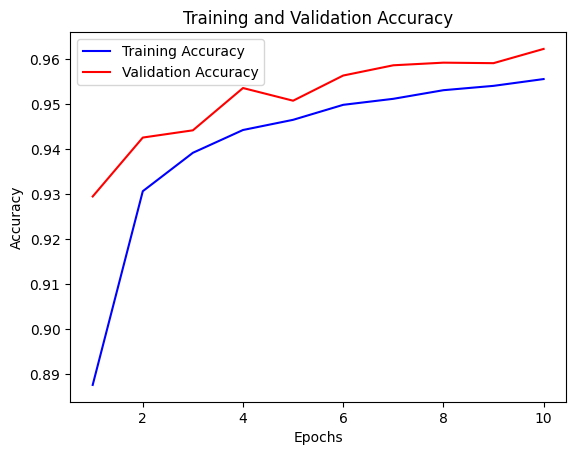

In [127]:
# Get training history
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(train_accuracy) + 1)

# Plot training and validation accuracy
plt.plot(epochs, train_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

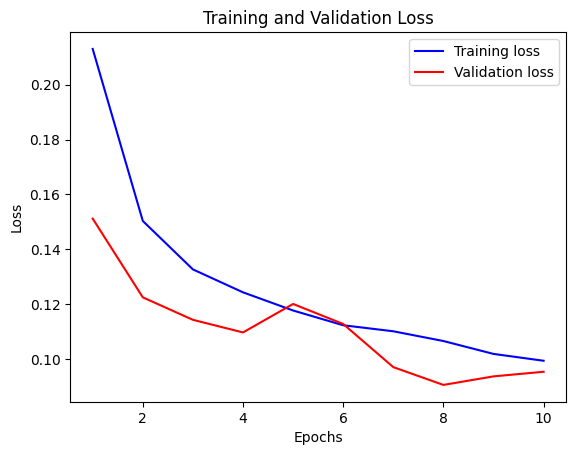

In [110]:
# Get the training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

# Plot the training and validation loss curves
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

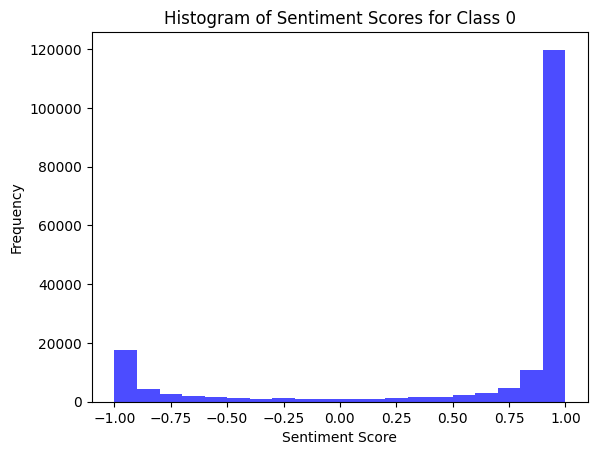

In [41]:
# Filter the dataset to include only samples with class generated 1
class_1_data = df[df['generated'] == 0]

# Histogram for sentiment scores of class 1
plt.hist(class_1_data['sentiment_score'], bins=20, color='blue', alpha=0.7)
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Histogram of Sentiment Scores for Class 0')
plt.show()

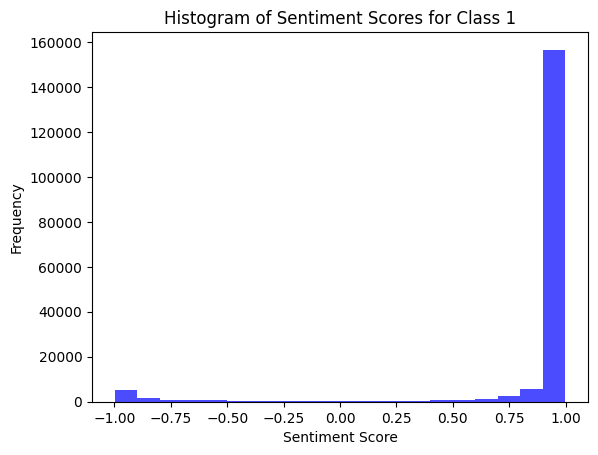

In [42]:
import matplotlib.pyplot as plt

# Filter the dataset to include only samples with class generated 1
class_1_data = df[df['generated'] == 1]

# Histogram for sentiment scores of class 1
plt.hist(class_1_data['sentiment_score'], bins=20, color='blue', alpha=0.7)
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Histogram of Sentiment Scores for Class 1')
plt.show()

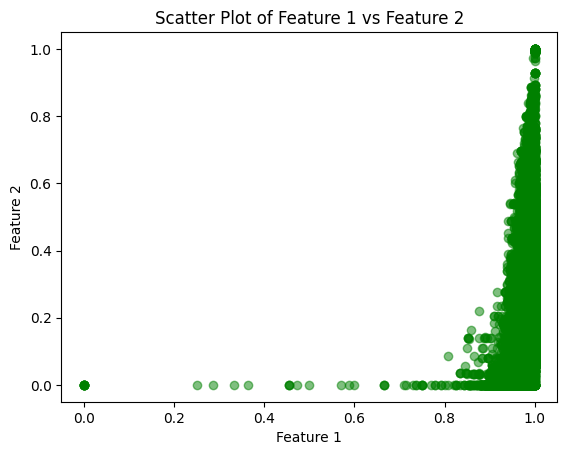

In [43]:
# Scatter plot for two numerical features with different colors
plt.scatter(df['pos_repetitiveness'], df['bigram_repetitiveness'], color=['green'], alpha=0.5) # change/ add whaterver numaric feature you want
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Scatter Plot of Feature 1 vs Feature 2')
plt.show()


In [44]:
# # List all columns in the DataFrame
# all_columns = df.columns.tolist()
# all_columns

In [45]:
# # Select only numeric columns
# numeric_columns = df.select_dtypes(include='number').columns.tolist()

# # Print the list of numeric columns
# print("Numeric Columns in the DataFrame:")
# for column in numeric_columns:
#     print(column)

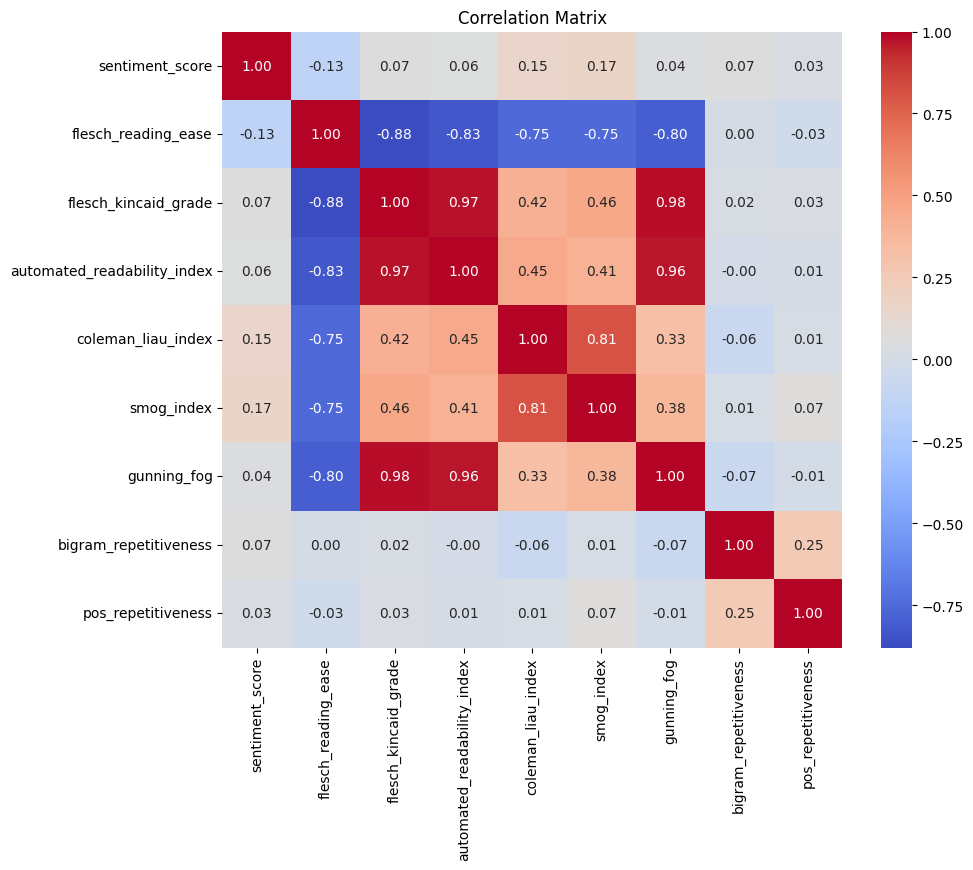

In [17]:
# List of specific columns you want to include
columns_to_include = ['sentiment_score', 'flesch_reading_ease', 'flesch_kincaid_grade', 'automated_readability_index', 'coleman_liau_index', 'smog_index', 'gunning_fog', 'bigram_repetitiveness', 'pos_repetitiveness']

# Select only the specified columns
df_selected = df[columns_to_include]

# Calculate correlation matrix
corr_matrix = df_selected.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [47]:
# # Specify the layer you want to visualize
# layer_name = 'dense'

# # Create a model that outputs the activations of the desired layer
# activation_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)

# # Get activations for a sample input
# activations = activation_model.predict([x_val[:, :bert_embeddings.shape[1]], x_val[:, bert_embeddings.shape[1]:bert_embeddings.shape[1]+1], x_val[:, bert_embeddings.shape[1]+1:bert_embeddings.shape[1]+7], x_val[:, bert_embeddings.shape[1]+7:]])

# # Ensure activations is 2-dimensional
# if len(activations.shape) == 4:
#     activations = activations[0]

# # Visualize activations
# plt.imshow(activations, cmap='viridis')
# plt.title('Activation of Layer {}'.format(layer_name))
# plt.colorbar()
# plt.show()

10. Evaluation

In [48]:
# # Reading the updated DataFrame
# df = pd.read_csv('Full_Featuers_DataSet_300thousand.csv')

In [49]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from transformers import BertTokenizer, TFBertModel
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textstat import textstat
from collections import Counter
from nltk import pos_tag, word_tokenize, ngrams

# Load the Testing dataset
AI_Human = pd.read_csv('AI_Human.csv')

# Sample 10,000 random records
random_samples = AI_Human.sample(n=100, random_state=42)

# Create a new DataFrame with the sampled data
df = pd.DataFrame(random_samples)

# Sample 4000 records from each class
sample_size_per_class = 10
class_0_indices = df[df['generated'] == 0].sample(sample_size_per_class).index
class_1_indices = df[df['generated'] == 1].sample(sample_size_per_class).index
sample_indices = np.concatenate([class_0_indices, class_1_indices])
sampled_dataset = df.loc[sample_indices].sample(frac=1)  # Shuffle the sampled dataset
sampled_dataset['text'] = sampled_dataset['text'].astype(str)

# Download necessary NLTK resources
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to get sentiment score for a given text
def get_sentiment_score(text):
    scores = analyzer.polarity_scores(text)
    return scores['compound']  # Compound score is a normalized score between -1 and 1

# Add a new column to store sentiment scores
sampled_dataset['sentiment_score'] = sampled_dataset['text'].apply(get_sentiment_score)

# # Function to calculate readability metrics
# def calculate_readability(text):
#     return {
#         'flesch_reading_ease': textstat.flesch_reading_ease(text),
#         'flesch_kincaid_grade': textstat.flesch_kincaid_grade(text),
#         'automated_readability_index': textstat.automated_readability_index(text),
#         'coleman_liau_index': textstat.coleman_liau_index(text),
#         'smog_index': textstat.smog_index(text),
#         'gunning_fog': textstat.gunning_fog(text)
#     }

# # Apply the function to calculate readability metrics for each text
# sampled_dataset['readability_metrics'] = sampled_dataset['text'].apply(calculate_readability)

# # Extract readability metrics into separate columns
# sampled_dataset['flesch_reading_ease'] = sampled_dataset['readability_metrics'].apply(lambda x: x['flesch_reading_ease'])
# sampled_dataset['flesch_kincaid_grade'] = sampled_dataset['readability_metrics'].apply(lambda x: x['flesch_kincaid_grade'])
# sampled_dataset['automated_readability_index'] = sampled_dataset['readability_metrics'].apply(lambda x: x['automated_readability_index'])
# sampled_dataset['coleman_liau_index'] = sampled_dataset['readability_metrics'].apply(lambda x: x['coleman_liau_index'])
# sampled_dataset['smog_index'] = sampled_dataset['readability_metrics'].apply(lambda x: x['smog_index'])
# sampled_dataset['gunning_fog'] = sampled_dataset['readability_metrics'].apply(lambda x: x['gunning_fog'])

# Function to calculate n-gram repetitiveness
def ngram_repetitiveness(text, n=2):
    words = text.split()
    n_grams = list(ngrams(words, n))
    ngram_counts = Counter(n_grams)
    repeats = {ngram: count for ngram, count in ngram_counts.items() if count > 1}
    repetitiveness_score = sum(repeats.values()) / len(n_grams) if n_grams else 0
    return repetitiveness_score

# Apply n-gram repetitiveness calculation for bigrams
sampled_dataset['bigram_repetitiveness'] = sampled_dataset['text'].apply(lambda x: ngram_repetitiveness(x, 2))

# Function to perform POS tagging on text
def pos_tagging(text):
    tokens = word_tokenize(text)
    pos_tags = pos_tag(tokens)
    return pos_tags

# Add a new column for POS tags
sampled_dataset['pos_tags'] = sampled_dataset['text'].apply(pos_tagging)

# Function to extract POS tag frequencies from a list of POS tags
def count_pos_tags(pos_tags):
    pos_tag_freq = Counter(tag for _, tag in pos_tags)  # Extract POS tag counts directly from tuples
    return dict(pos_tag_freq)

# Calculate POS tag frequencies for each sample
sampled_dataset['pos_tag_freq'] = sampled_dataset['pos_tags'].apply(count_pos_tags)
pos_tags_df = pd.DataFrame(sampled_dataset['pos_tag_freq'].tolist()).fillna(0)

# Define all possible POS tags
all_pos_tags = ['NNP', 'CC', '(', 'CD', 'VBD', ')', 'DT', 'JJ', 'NN', '.', 'PRP$', 'IN', 'POS', ',', 'WRB', 'PRP', 'NNS', 'WDT', 'VBZ', 'VBN', 'VBG', 'RB', 'VB', 'SYM', ':', 'MD', '$', 'JJS', 'VBP', 'FW', 'WP', 'TO', 'RP', '``', 'NNPS', 'UH', 'JJR', 'RBS', 'EX', 'PDT', 'RBR', 'WP$', '#', 'LS']

# Ensure all required POS tag columns are present
for pos_tag in all_pos_tags:
    if pos_tag not in pos_tags_df.columns:
        pos_tags_df[pos_tag] = 0  # Fill with zeros if the column is missing

# Reset indices if necessary
sampled_dataset.reset_index(drop=True, inplace=True)
pos_tags_df.reset_index(drop=True, inplace=True)

# Concatenate the POS tag features with the original dataset
sampled_dataset = pd.concat([sampled_dataset, pos_tags_df], axis=1)

# Function to calculate POS repetitiveness
def pos_repetitiveness(pos_tags):
    tag_sequences = [tag for _, tag in pos_tags]
    tag_counts = Counter(tag_sequences)
    repeats = {tag: count for tag, count in tag_counts.items() if count > 1}
    repetitiveness_score = sum(repeats.values()) / len(tag_sequences) if tag_sequences else 0
    return repetitiveness_score

# Apply POS structural repetitiveness calculation
sampled_dataset['pos_repetitiveness'] = sampled_dataset['pos_tags'].apply(pos_repetitiveness)

# Load BERT tokenizer and model
print("Loading BERT tokenizer and model...")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

# Tokenize input text
print("Tokenizing input text...")
input_text = sampled_dataset['text'].tolist()
input_text = [text[:512] for text in input_text]  # Limit sequence length to 512 tokens
input_ids = tokenizer(input_text, padding=True, truncation=True, return_tensors="tf")["input_ids"]

# Get BERT embeddings
print("Getting BERT embeddings...")
batch_size = 64
num_samples = len(input_ids)
pooled_outputs_list = []

# Process inputs in batches
for i in range(0, num_samples, batch_size):
    batch_input_ids = input_ids[i:i+batch_size]
    batch_outputs = bert_model(batch_input_ids)
    batch_pooled_output = batch_outputs.pooler_output
    pooled_outputs_list.append(batch_pooled_output)

# Concatenate pooled outputs from all batches
pooled_output = tf.concat(pooled_outputs_list, axis=0)

# Extract features
sentiment_scores = sampled_dataset['sentiment_score'].values.reshape(-1, 1)  # Ensure 2D shape
# readability_metrics = sampled_dataset[['flesch_reading_ease', 'flesch_kincaid_grade', 'automated_readability_index', 'coleman_liau_index', 'smog_index', 'gunning_fog']].values  # Ensure 2D shape
repetitiveness_scores = sampled_dataset[['bigram_repetitiveness', 'pos_repetitiveness']].values  # Ensure 2D shape
pos_tags_input = sampled_dataset[all_pos_tags].values  # Ensure each POS tag feature is included

# Concatenate all features
input_data = {
    'bert_input': pooled_output.numpy(),  # BERT embeddings
    'sentiment_input': sentiment_scores,  # Sentiment scores
    # 'readability_input': readability_metrics,  # Readability metrics
    'repetitiveness_input': repetitiveness_scores,  # Repetitiveness scores
    'pos_tags_input': pos_tags_input  # POS tags
}

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\abura\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\abura\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\abura\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Loading BERT tokenizer and model...


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Tokenizing input text...
Getting BERT embeddings...


In [5]:
# # testing on my huggin face datsets df named df_test

# import numpy as np
# import pandas as pd
# import tensorflow as tf
# from sklearn.metrics import confusion_matrix
# from transformers import BertTokenizer, TFBertModel
# import nltk
# from nltk.sentiment.vader import SentimentIntensityAnalyzer
# from textstat import textstat
# from collections import Counter
# from nltk import pos_tag, word_tokenize, ngrams

# # Load the Testing dataset
# AI_Human = pd.read_csv('AI_Human.csv')

# # Sample 10,000 random records
# random_samples = AI_Human.sample(n=100, random_state=42)

# # Create a new DataFrame with the sampled data
# df = pd.DataFrame(random_samples)

# # Sample 4000 records from each class
# sample_size_per_class = 10
# class_0_indices = df[df['generated'] == 0].sample(sample_size_per_class).index
# class_1_indices = df[df['generated'] == 1].sample(sample_size_per_class).index
# sample_indices = np.concatenate([class_0_indices, class_1_indices])
# sampled_dataset = df.loc[sample_indices].sample(frac=1)  # Shuffle the sampled dataset
# sampled_dataset['text'] = sampled_dataset['text'].astype(str)

sampled_dataset2 = df_test

# Download necessary NLTK resources
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to get sentiment score for a given text
def get_sentiment_score(text):
    scores = analyzer.polarity_scores(text)
    return scores['compound']  # Compound score is a normalized score between -1 and 1

# Add a new column to store sentiment scores
sampled_dataset['sentiment_score'] = sampled_dataset['text'].apply(get_sentiment_score)

# Function to calculate readability metrics
def calculate_readability(text):
    return {
        'flesch_reading_ease': textstat.flesch_reading_ease(text),
        'flesch_kincaid_grade': textstat.flesch_kincaid_grade(text),
        'automated_readability_index': textstat.automated_readability_index(text),
        'coleman_liau_index': textstat.coleman_liau_index(text),
        'smog_index': textstat.smog_index(text),
        'gunning_fog': textstat.gunning_fog(text)
    }

# Apply the function to calculate readability metrics for each text
sampled_dataset2['readability_metrics'] = sampled_dataset2['text'].apply(calculate_readability)

# Extract readability metrics into separate columns
sampled_dataset2['flesch_reading_ease'] = sampled_dataset2['readability_metrics'].apply(lambda x: x['flesch_reading_ease'])
sampled_dataset2['flesch_kincaid_grade'] = sampled_dataset2['readability_metrics'].apply(lambda x: x['flesch_kincaid_grade'])
sampled_dataset2['automated_readability_index'] = sampled_dataset2['readability_metrics'].apply(lambda x: x['automated_readability_index'])
sampled_dataset2['coleman_liau_index'] = sampled_dataset2['readability_metrics'].apply(lambda x: x['coleman_liau_index'])
sampled_dataset2['smog_index'] = sampled_dataset2['readability_metrics'].apply(lambda x: x['smog_index'])
sampled_dataset2['gunning_fog'] = sampled_dataset2['readability_metrics'].apply(lambda x: x['gunning_fog'])

# Function to calculate n-gram repetitiveness
def ngram_repetitiveness(text, n=2):
    words = text.split()
    n_grams = list(ngrams(words, n))
    ngram_counts = Counter(n_grams)
    repeats = {ngram: count for ngram, count in ngram_counts.items() if count > 1}
    repetitiveness_score = sum(repeats.values()) / len(n_grams) if n_grams else 0
    return repetitiveness_score

# Apply n-gram repetitiveness calculation for bigrams
sampled_dataset2['bigram_repetitiveness'] = sampled_dataset2['text'].apply(lambda x: ngram_repetitiveness(x, 2))

# Function to perform POS tagging on text
def pos_tagging(text):
    tokens = word_tokenize(text)
    pos_tags = pos_tag(tokens)
    return pos_tags

# Add a new column for POS tags
sampled_dataset2['pos_tags'] = sampled_dataset2['text'].apply(pos_tagging)

# Function to extract POS tag frequencies from a list of POS tags
def count_pos_tags(pos_tags):
    pos_tag_freq = Counter(tag for _, tag in pos_tags)  # Extract POS tag counts directly from tuples
    return dict(pos_tag_freq)

# Calculate POS tag frequencies for each sample
sampled_dataset2['pos_tag_freq'] = sampled_dataset2['pos_tags'].apply(count_pos_tags)
pos_tags_df = pd.DataFrame(sampled_dataset2['pos_tag_freq'].tolist()).fillna(0)

# Define all possible POS tags
all_pos_tags = ['NNP', 'CC', '(', 'CD', 'VBD', ')', 'DT', 'JJ', 'NN', '.', 'PRP$', 'IN', 'POS', ',', 'WRB', 'PRP', 'NNS', 'WDT', 'VBZ', 'VBN', 'VBG', 'RB', 'VB', 'SYM', ':', 'MD', '$', 'JJS', 'VBP', 'FW', 'WP', 'TO', 'RP', '``', 'NNPS', 'UH', 'JJR', 'RBS', 'EX', 'PDT', 'RBR', 'WP$', '#', 'LS']

# Ensure all required POS tag columns are present
for pos_tag in all_pos_tags:
    if pos_tag not in pos_tags_df.columns:
        pos_tags_df[pos_tag] = 0  # Fill with zeros if the column is missing

# Reset indices if necessary
sampled_dataset2.reset_index(drop=True, inplace=True)
pos_tags_df.reset_index(drop=True, inplace=True)

# Concatenate the POS tag features with the original dataset
sampled_dataset2 = pd.concat([sampled_dataset2, pos_tags_df], axis=1)

# Function to calculate POS repetitiveness
def pos_repetitiveness(pos_tags):
    tag_sequences = [tag for _, tag in pos_tags]
    tag_counts = Counter(tag_sequences)
    repeats = {tag: count for tag, count in tag_counts.items() if count > 1}
    repetitiveness_score = sum(repeats.values()) / len(tag_sequences) if tag_sequences else 0
    return repetitiveness_score

# Apply POS structural repetitiveness calculation
sampled_dataset2['pos_repetitiveness'] = sampled_dataset2['pos_tags'].apply(pos_repetitiveness)

# Load BERT tokenizer and model
print("Loading BERT tokenizer and model...")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

# Tokenize input text
print("Tokenizing input text...")
input_text = df_test['text'].tolist()
input_text = [text[:512] for text in input_text]  # Limit sequence length to 512 tokens
input_ids = tokenizer(input_text, padding=True, truncation=True, return_tensors="tf")["input_ids"]

# Get BERT embeddings
print("Getting BERT embeddings...")
batch_size = 64
num_samples = len(input_ids)
pooled_outputs_list = []

# Process inputs in batches
for i in range(0, num_samples, batch_size):
    batch_input_ids = input_ids[i:i+batch_size]
    batch_outputs = bert_model(batch_input_ids)
    batch_pooled_output = batch_outputs.pooler_output
    pooled_outputs_list.append(batch_pooled_output)

# Concatenate pooled outputs from all batches
pooled_output = tf.concat(pooled_outputs_list, axis=0)

# Extract features
sentiment_scores = sampled_dataset2['sentiment_score'].values.reshape(-1, 1)  # Ensure 2D shape
readability_metrics = sampled_dataset2[['flesch_reading_ease', 'flesch_kincaid_grade', 'automated_readability_index', 'coleman_liau_index', 'smog_index', 'gunning_fog']].values  # Ensure 2D shape
repetitiveness_scores = sampled_dataset2[['bigram_repetitiveness', 'pos_repetitiveness']].values  # Ensure 2D shape
pos_tags_input = sampled_dataset2[all_pos_tags].values  # Ensure each POS tag feature is included

# Concatenate all features
input_data = {
    'bert_input': pooled_output.numpy(),  # BERT embeddings
    'sentiment_input': sentiment_scores,  # Sentiment scores
    'readability_input': readability_metrics,  # Readability metrics
    'repetitiveness_input': repetitiveness_scores,  # Repetitiveness scores
    'pos_tags_input': pos_tags_input  # POS tags
}

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\abura\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\abura\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\abura\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Loading BERT tokenizer and model...


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Tokenizing input text...
Getting BERT embeddings...


In [54]:
sampled_dataset = df_test

In [55]:
# Function to calculate readability metrics
def calculate_readability(text):
    return {
        'flesch_reading_ease': textstat.flesch_reading_ease(text),
        'flesch_kincaid_grade': textstat.flesch_kincaid_grade(text),
        'automated_readability_index': textstat.automated_readability_index(text),
        'coleman_liau_index': textstat.coleman_liau_index(text),
        'smog_index': textstat.smog_index(text),
        'gunning_fog': textstat.gunning_fog(text)
    }

# Apply the function to calculate readability metrics for each text
sampled_dataset['readability_metrics'] = sampled_dataset['text'].apply(calculate_readability)

# Extract readability metrics into separate columns
sampled_dataset['flesch_reading_ease'] = sampled_dataset['readability_metrics'].apply(lambda x: x['flesch_reading_ease'])
sampled_dataset['flesch_kincaid_grade'] = sampled_dataset['readability_metrics'].apply(lambda x: x['flesch_kincaid_grade'])
sampled_dataset['automated_readability_index'] = sampled_dataset['readability_metrics'].apply(lambda x: x['automated_readability_index'])
sampled_dataset['coleman_liau_index'] = sampled_dataset['readability_metrics'].apply(lambda x: x['coleman_liau_index'])
sampled_dataset['smog_index'] = sampled_dataset['readability_metrics'].apply(lambda x: x['smog_index'])
sampled_dataset['gunning_fog'] = sampled_dataset['readability_metrics'].apply(lambda x: x['gunning_fog'])

In [56]:
readability_metrics = sampled_dataset[['flesch_reading_ease', 'flesch_kincaid_grade', 'automated_readability_index', 'coleman_liau_index', 'smog_index', 'gunning_fog']].values  # Ensure 2D shape

In [79]:
sampled_dataset = df_test

In [80]:
sampled_dataset

,text,generated
0,"Crosshill is an area of Glasgow, Scotland. It ...",0
1,Basic Communication Skills at Work Places Essa...,0
2,Emirates General Petroleum Corporation: Managi...,0
3,B: a considerate and kind friend.,1
4,How does marijuana affect the brain? Research ...,0
...,...,...
9995,Red Pepper Ragout:\n\nIngredients:\n- 3 red be...,1
9996,D). understory.\n\nFerns are common in the und...,1
9997,"The phrase ""is smart writing, skewed character...",1
9998,We Five was a 1960s folk rock musical group ba...,0


In [81]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from transformers import BertTokenizer, TFBertModel
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textstat import textstat
from collections import Counter
from nltk import pos_tag, word_tokenize, ngrams

# Download necessary NLTK resources
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to get sentiment score for a given text
def get_sentiment_score(text):
    scores = analyzer.polarity_scores(text)
    return scores['compound']  # Compound score is a normalized score between -1 and 1

# Function to calculate n-gram repetitiveness
def ngram_repetitiveness(text, n=2):
    words = text.split()
    n_grams = list(ngrams(words, n))
    ngram_counts = Counter(n_grams)
    repeats = {ngram: count for ngram, count in ngram_counts.items() if count > 1}
    repetitiveness_score = sum(repeats.values()) / len(n_grams) if n_grams else 0
    return repetitiveness_score

# Function to perform POS tagging on text
def pos_tagging(text):
    tokens = word_tokenize(text)
    pos_tags = pos_tag(tokens)
    return pos_tags

# Function to extract POS tag frequencies from a list of POS tags
def count_pos_tags(pos_tags):
    pos_tag_freq = Counter(tag for _, tag in pos_tags)  # Extract POS tag counts directly from tuples
    return dict(pos_tag_freq)

# Function to calculate POS repetitiveness
def pos_repetitiveness(pos_tags):
    tag_sequences = [tag for _, tag in pos_tags]
    tag_counts = Counter(tag_sequences)
    repeats = {tag: count for tag, count in tag_counts.items() if count > 1}
    repetitiveness_score = sum(repeats.values()) / len(tag_sequences) if tag_sequences else 0
    return repetitiveness_score

# Add a new column to store sentiment scores
sampled_dataset['sentiment_score'] = sampled_dataset['text'].apply(get_sentiment_score)

# Apply n-gram repetitiveness calculation for bigrams
sampled_dataset['bigram_repetitiveness'] = sampled_dataset['text'].apply(lambda x: ngram_repetitiveness(x, 2))

# Add a new column for POS tags
sampled_dataset['pos_tags'] = sampled_dataset['text'].apply(pos_tagging)

# Calculate POS tag frequencies for each sample
sampled_dataset['pos_tag_freq'] = sampled_dataset['pos_tags'].apply(count_pos_tags)
pos_tags_df = pd.DataFrame(sampled_dataset['pos_tag_freq'].tolist()).fillna(0)

# Define all possible POS tags
all_pos_tags = ['NNP', 'CC', '(', 'CD', 'VBD', ')', 'DT', 'JJ', 'NN', '.', 'PRP$', 'IN', 'POS', ',', 'WRB', 'PRP', 'NNS', 'WDT', 'VBZ', 'VBN', 'VBG', 'RB', 'VB', 'SYM', ':', 'MD', '$', 'JJS', 'VBP', 'FW', 'WP', 'TO', 'RP', '``', 'NNPS', 'UH', 'JJR', 'RBS', 'EX', 'PDT', 'RBR', 'WP$', '#', 'LS']

# Ensure all required POS tag columns are present
for pos_tag in all_pos_tags:
    if pos_tag not in pos_tags_df.columns:
        pos_tags_df[pos_tag] = 0  # Fill with zeros if the column is missing

# Reset indices if necessary
sampled_dataset.reset_index(drop=True, inplace=True)
pos_tags_df.reset_index(drop=True, inplace=True)

# Concatenate the POS tag features with the original dataset
sampled_dataset = pd.concat([sampled_dataset, pos_tags_df], axis=1)

# Apply POS structural repetitiveness calculation
sampled_dataset['pos_repetitiveness'] = sampled_dataset['pos_tags'].apply(pos_repetitiveness)

# Load BERT tokenizer and model
print("Loading BERT tokenizer and model...")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

# Tokenize input text
print("Tokenizing input text...")
input_text = sampled_dataset['text'].tolist()
input_text = [text[:512] for text in input_text]  # Limit sequence length to 512 tokens
input_ids = tokenizer(input_text, padding=True, truncation=True, return_tensors="tf")["input_ids"]

# Get BERT embeddings
print("Getting BERT embeddings...")
batch_size = 64
num_samples = len(input_ids)
pooled_outputs_list = []

# Process inputs in batches
for i in range(0, num_samples, batch_size):
    batch_input_ids = input_ids[i:i+batch_size]
    batch_outputs = bert_model(batch_input_ids)
    batch_pooled_output = batch_outputs.pooler_output
    pooled_outputs_list.append(batch_pooled_output)

# Concatenate pooled outputs from all batches
pooled_output = tf.concat(pooled_outputs_list, axis=0)

# Extract features
sentiment_scores = sampled_dataset['sentiment_score'].values.reshape(-1, 1)  # Ensure 2D shape
repetitiveness_scores = sampled_dataset[['bigram_repetitiveness', 'pos_repetitiveness']].values  # Ensure 2D shape
pos_tags_input = sampled_dataset[all_pos_tags].values  # Ensure each POS tag feature is included

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\abura\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\abura\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\abura\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Loading BERT tokenizer and model...


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Tokenizing input text...
Getting BERT embeddings...


In [82]:
# Concatenate all features
input_data = {
    'bert_input': pooled_output.numpy(),  # BERT embeddings
    'sentiment_input': sentiment_scores,  # Sentiment scores
    # 'readability_input': readability_metrics,  # Readability metrics
    'repetitiveness_input': repetitiveness_scores,  # Repetitiveness scores
    'pos_tags_input': pos_tags_input  # POS tags
}

In [31]:
pos_tags_input.shape

(2000, 88)

313/313 [==============================] - 1s 2ms/step


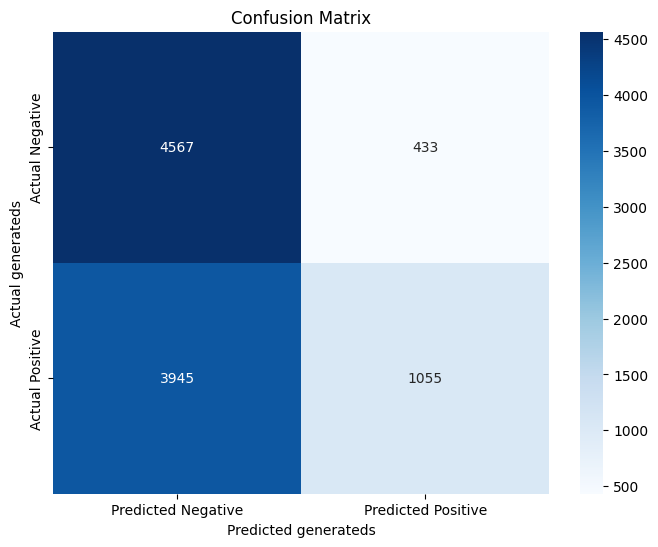

In [106]:
# Load the trained classification model
model = tf.keras.models.load_model('bert_embeddings_360thousand_Full_Featuers_DataSet_360thousand_test_2.h5')

# Predict classes for each record
predictions = model.predict(input_data)

# Convert probabilities to binary predictions based on threshold (0.5)
binary_predictions = (predictions > 0.5).astype(int)

# Confusion matrix from your code
conf_matrix = confusion_matrix(df_test['generated'], binary_predictions)

# Visualizing the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted generateds')
plt.ylabel('Actual generateds')
plt.show()

In [84]:
# Define true generateds and predicted generateds based on confusion matrix
true_generateds = sampled_dataset['generated']
predicted_generateds = binary_predictions

# Calculate accuracy
accuracy = accuracy_score(true_generateds, predicted_generateds)

# Calculate precision
precision = precision_score(true_generateds, predicted_generateds)

# Calculate recall
recall = recall_score(true_generateds, predicted_generateds)

# Calculate F1-score
f1 = f1_score(true_generateds, predicted_generateds)

# Print the metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.7681
Precision: 0.7693389592123769
Recall: 0.7658
F1-score: 0.7675654004209682


10. Visulazation that needs predictions / confusion matrix

Notes:
1) y_pred_probs =  hist

1/1 [==============================] - 0s 25ms/step


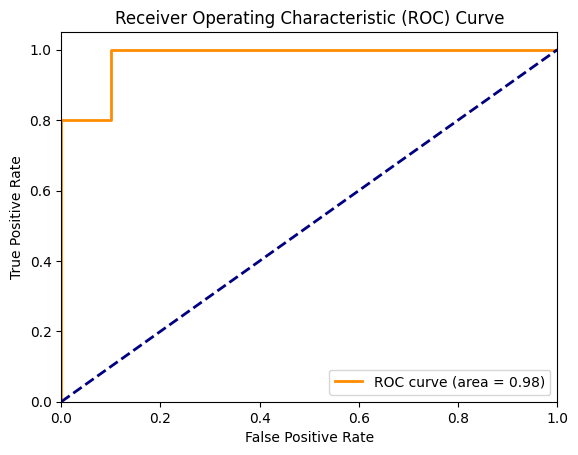

In [52]:
y_true = sampled_dataset['generated'].values

# If your model returns probabilities and you need binary predictions:
y_pred = (predictions > 0.5).astype(int)

# If you want to use probabilities directly for ROC:
y_pred_probs = model.predict(input_data)

from sklearn.metrics import roc_curve, roc_auc_score

# Assuming y_pred_probs only contains one probability per instance, corresponding to the positive class
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)  # Directly use y_pred_probs
roc_auc = roc_auc_score(y_true, y_pred_probs)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [53]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.model_selection import learning_curve
# from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# # Define the model creation function
# def create_model():
#     input_layer_bert = Input(shape=(768,), name='bert_input')
#     input_layer_sentiment = Input(shape=(1,), name='sentiment_input')
#     input_layer_readability = Input(shape=(6,), name='readability_input')
#     input_layer_repetitiveness = Input(shape=(2,), name='repetitiveness_input')
#     input_layer_pos_tags = Input(shape=(44,), name='pos_tags_input')

#     processed_sentiment = Dense(32, activation='relu')(input_layer_sentiment)
#     processed_readability = Dense(64, activation='relu')(input_layer_readability)
#     processed_repetitiveness = Dense(32, activation='relu')(input_layer_repetitiveness)
#     processed_pos_tags = Dense(32, activation='relu')(input_layer_pos_tags)

#     concatenated = concatenate([input_layer_bert, processed_sentiment, processed_readability, processed_repetitiveness, processed_pos_tags])

#     x = Dense(128, activation='relu')(concatenated)
#     x = Dropout(0.5)(x)
#     x = Dense(64, activation='relu')(x)
#     x = Dropout(0.3)(x)
#     classification_layer = Dense(1, activation='sigmoid')(x)

#     model = Model(inputs=[input_layer_bert, input_layer_sentiment, input_layer_readability, input_layer_repetitiveness, input_layer_pos_tags], outputs=classification_layer)
#     model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#     return model

# # Wrap the model using KerasClassifier
# estimator = KerasClassifier(build_fn=create_model, epochs=10, batch_size=32, verbose=0)

# # Prepare the dataset
# X = {
#     'bert_input': pooled_output.numpy(),
#     'sentiment_input': sampled_dataset['sentiment_score'].values.reshape(-1, 1),
#     'readability_input': sampled_dataset[['flesch_reading_ease', 'flesch_kincaid_grade', 'automated_readability_index', 'coleman_liau_index', 'smog_index', 'gunning_fog']].values,
#     'repetitiveness_input': sampled_dataset[['bigram_repetitiveness', 'pos_repetitiveness']].values,
#     'pos_tags_input': sampled_dataset[['NNP', 'CC', '(', 'CD', 'VBD', ')', 'DT', 'JJ', 'NN', '.', 'PRP$', 'IN', 'POS', ',', 'WRB', 'PRP', 'NNS', 'WDT', 'VBZ', 'VBN', 'VBG', 'RB', 'VB', 'SYM', ':', 'MD', '$', 'JJS', 'VBP', 'FW', 'WP', 'TO', 'RP', '``', 'NNPS', 'UH', 'JJR', 'RBS', 'EX', 'PDT', 'RBR', 'WP$', '#', 'LS']].values
# }
# y = sampled_dataset['generated']

# # Generate learning curves
# train_sizes, train_scores, val_scores = learning_curve(
#     estimator,
#     X,
#     y,
#     train_sizes=np.linspace(0.1, 1.0, 10),
#     cv=5
# )

# # Calculate mean and standard deviation of training and validation scores
# train_mean = np.mean(train_scores, axis=1)
# train_std = np.std(train_scores, axis=1)
# val_mean = np.mean(val_scores, axis=1)
# val_std = np.std(val_scores, axis=1)

# # Plot learning curve
# plt.figure(figsize=(10, 6))
# plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, generated='Training Accuracy')
# plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
# plt.plot(train_sizes, val_mean, color='green', linestyle='--', marker='s', markersize=5, generated='Validation Accuracy')
# plt.fill_between(train_sizes, val_mean + val_std, val_mean - val_std, alpha=0.15, color='green')
# plt.title('Learning Curve')
# plt.xgenerated('Training Samples')
# plt.ygenerated('Accuracy')
# plt.legend(loc='lower right')
# plt.grid()
# plt.show()


In [54]:
# from sklearn.metrics import precision_recall_curve, auc

# precision, recall, _ = precision_recall_curve(y_val, y_pred_probs) # numbers of samples must be equal: [24000, 10]
# pr_auc = auc(recall, precision)

# plt.plot(recall, precision, generated=f'PR curve (area = {pr_auc:.4f})')
# plt.xgenerated('Recall')
# plt.ygenerated('Precision')
# plt.title('Precision-Recall Curve')
# plt.legend(loc='lower left')
# plt.show()

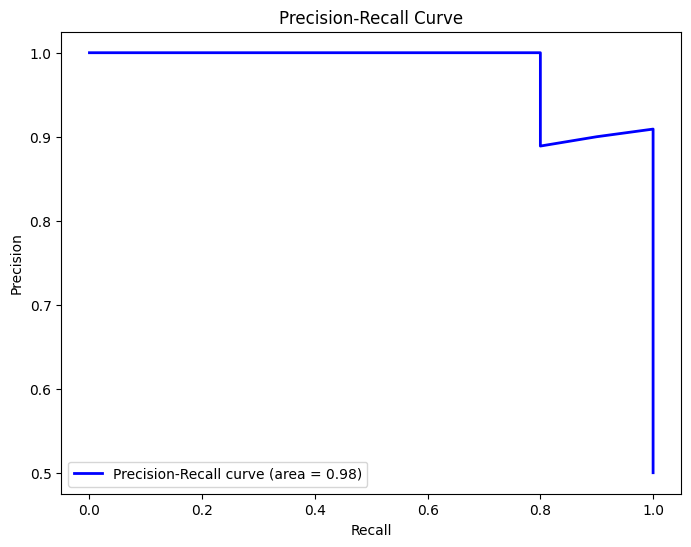

In [55]:
from sklearn.metrics import precision_recall_curve, auc

# Calculate precision and recall from model probabilities
precision, recall, _ = precision_recall_curve(sampled_dataset['generated'], predictions)
pr_auc = auc(recall, precision)

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (area = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

11.Evaluation (single text)

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textstat import textstat
from collections import Counter
from nltk import pos_tag, word_tokenize, ngrams

# Load BERT tokenizer and model
print("Loading BERT tokenizer and model...")
bert_model = TFBertModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Initialize VADER sentiment analyzer
nltk.download('vader_lexicon')
analyzer = SentimentIntensityAnalyzer()

# Function to calculate n-gram repetitiveness
def ngram_repetitiveness(text, n=2):
    words = text.split()
    n_grams = list(ngrams(words, n))
    ngram_counts = Counter(n_grams)
    repeats = {ngram: count for ngram, count in ngram_counts.items() if count > 1}
    repetitiveness_score = sum(repeats.values()) / len(n_grams) if n_grams else 0
    return repetitiveness_score

# Function to calculate POS repetitiveness
def pos_repetitiveness(pos_tags):
    tag_sequences = [tag for _, tag in pos_tags]
    tag_counts = Counter(tag_sequences)
    repeats = {tag: count for tag, count in tag_counts.items() if count > 1}
    repetitiveness_score = sum(repeats.values()) / len(tag_sequences) if tag_sequences else 0
    return repetitiveness_score

def preprocess_text(text):
    # Get sentiment score
    sentiment_score = analyzer.polarity_scores(text)['compound']

    # Tokenize input text
    input_ids = tokenizer(text, padding=True, truncation=True, return_tensors="tf")["input_ids"]

    # Get BERT embeddings
    outputs = bert_model(input_ids)
    pooled_output = outputs.pooler_output.numpy()

    # Calculate readability metrics
    readability_metrics = textstat.flesch_reading_ease(text), \
                           textstat.flesch_kincaid_grade(text), \
                           textstat.automated_readability_index(text), \
                           textstat.coleman_liau_index(text), \
                           textstat.smog_index(text), \
                           textstat.gunning_fog(text)

    # Calculate n-gram repetitiveness
    bigram_repetitiveness = ngram_repetitiveness(text, n=2)

    # Perform POS tagging
    tokens = word_tokenize(text)
    pos_tags = pos_tag(tokens)

    # Calculate POS tag frequencies
    pos_tag_freq = Counter(tag for _, tag in pos_tags)

    # Define all possible POS tags
    all_pos_tags = ['NNP', 'CC', '(', 'CD', 'VBD', ')', 'DT', 'JJ', 'NN', '.', 'PRP$', 'IN', 'POS', ',', 'WRB', 'PRP', 'NNS', 'WDT', 'VBZ', 'VBN', 'VBG', 'RB', 'VB', 'SYM', ':', 'MD', '$', 'JJS', 'VBP', 'FW', 'WP', 'TO', 'RP', '``', 'NNPS', 'UH', 'JJR', 'RBS', 'EX', 'PDT', 'RBR', 'WP$', '#', 'LS']
    # Ensure all required POS tag columns are present
    pos_tags_input = np.array([pos_tag_freq.get(tag, 0) for tag in all_pos_tags]).reshape(1, -1)

    # Calculate POS structural repetitiveness
    pos_rep_score = pos_repetitiveness(pos_tags)

    # Prepare input data for prediction
    input_data = {
        'bert_input': pooled_output,
        'sentiment_input': np.array([[sentiment_score]]),
        # 'readability_input': np.array([readability_metrics]),
        'repetitiveness_input': np.array([[bigram_repetitiveness, pos_rep_score]]),
        'pos_tags_input': pos_tags_input
    }

    return input_data

def predict(text):
    # Preprocess the input text
    input_data = preprocess_text(text)

    # Load saved model
    loaded_model = tf.keras.models.load_model('bert_embeddings_360thousand_Full_Featuers_DataSet_360thousand_test_2.h5')

    # Make predictions
    predictions = loaded_model.predict(input_data)

    return predictions

# Sample new input text for prediction
new_input_text = '''

The Role of Music in Human Life
Music has been an integral part of human culture for thousands of years. It transcends boundaries, bringing people together and expressing emotions in a way that words alone cannot. This essay explores the various roles music plays in human life, from its impact on emotional well-being to its ability to foster social connections and cultural understanding.

Emotional Expression and Healing
One of the most powerful aspects of music is its ability to express and evoke emotions. Whether it’s a soothing melody that calms the mind or an upbeat tune that energizes the body, music has a profound impact on our emotional state. Listening to music can help individuals process their feelings, providing a sense of comfort and relief during difficult times.

Music therapy is a recognized field that uses music to improve mental health and well-being. Therapists use musical activities to help patients express themselves, manage stress, and improve their overall mood. For example, patients with depression might find solace in playing an instrument or singing, which can serve as an outlet for their emotions. The therapeutic power of music extends to physical health as well

'''

# Make predictions
predictions = predict(new_input_text)

# Print predictions
print("Predictions:", predictions)


c:\Users\abura\miniconda3\envs\GP2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading BERT tokenizer and model...


SSLError: (MaxRetryError('HTTPSConnectionPool(host=\'huggingface.co\', port=443): Max retries exceeded with url: /bert-base-uncased/resolve/main/config.json (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for \'huggingface.co\'. (_ssl.c:1007)")))'), '(Request ID: 6dddd3bf-cd83-40b7-89c6-291c2adcba47)')

In [57]:
# # Sample new input text for prediction using bert embs only

# new_input_text = '''

# '''

# # Get sentiment score for the input text
# # sentiment_score = get_sentiment_score(new_input_text)

# # Load BERT tokenizer and model
# print("Loading BERT tokenizer and model...")
# bert_model = TFBertModel.from_pretrained('bert-base-uncased')
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# # Tokenize input text
# print("Tokenizing input text...")
# input_ids = tokenizer(new_input_text, padding=True, truncation=True, return_tensors="tf")["input_ids"]

# # Get BERT embeddings
# print("Getting BERT embeddings...")
# outputs = bert_model(input_ids)
# pooled_output = outputs.pooler_output

# # # Convert sentiment score to numpy array
# # sentiment_input = np.array([[sentiment_score]])

# # # Concatenate sentiment score with pooled_output
# # input_data = ([pooled_output, sentiment_input])
# input_data = ([pooled_output])
# # Load saved model
# loaded_model = tf.keras.models.load_model('bert_embeddings_120thousand_without_sentimant_onelayer.h5')

# # Make predictions
# print("Making predictions on new input...")
# predictions = loaded_model.predict(input_data)

# # Print predictions
# print("Predictions:", predictions)


11. Deep Analysis Techniques

In [58]:
# # Assume `sampled_dataset['text']` contains the original text, and `sampled_dataset['generated']` contains the true generateds
# error_analysis_df = pd.DataFrame({
#     'text': sampled_dataset['text'],
#     'true_generated': sampled_dataset['generated'],
#     'predicted_generated': binary_predictions.flatten(),  # Assuming binary_predictions is a column vector
#     'predicted_prob': predictions.flatten(),  # Assuming predictions is a column vector
# })

In [59]:
# misclassified = error_analysis_df[error_analysis_df['true_generated'] != error_analysis_df['predicted_generated']]

In [60]:
# # Print out examples of misclassified texts
# for index, row in misclassified.sample(10).iterrows():  # Randomly sample some misclassifications
#     print(f"Text: {row['text']}")
#     print(f"True generated: {row['true_generated']}, Predicted generated: {row['predicted_generated']}, Predicted Prob: {row['predicted_prob']}\n")


In [61]:
# # Summary statistics for probabilities in the misclassified examples
# print(misclassified['predicted_prob'].describe())

In [62]:
# # Histogram of predicted probabilities for misclassified examples
# plt.hist(misclassified['predicted_prob'], bins=50, alpha=0.5)
# plt.title('Histogram of Predicted Probabilities for Misclassified Examples')
# plt.xgenerated('Predicted Probability')
# plt.ygenerated('Frequency')
# plt.show()

12. Might Need Codes

In [63]:
# class_counts = AI_Human_DF['generated'].value_counts()
# print(class_counts)

In [64]:
# df.rename(columns={'generated': 'generated'}, inplace=True)
# df.drop(columns=['generated'], inplace=True)
# df.head(2)

In [65]:
# # Prepare additional features
# sentiment_scores = sampled_dataset['sentiment_score'].values.reshape(-1, 1)
# pos_tag_freq = sampled_dataset['pos_tag_freq'].apply(lambda x: list(x.values())).tolist()
# readability_metrics = sampled_dataset[['flesch_reading_ease', 'flesch_kincaid_grade', 'automated_readability_index', 'coleman_liau_index', 'smog_index', 'gunning_fog']].values
# repetitiveness_scores = sampled_dataset[['bigram_repetitiveness', 'pos_repetitiveness']].values

# # Concatenate all features
# input_data = np.concatenate([pooled_output.numpy(), sentiment_scores, pos_tag_freq, readability_metrics, repetitiveness_scores], axis=1)

In [66]:
# # Assuming sampled_dataset contains the required features
# # Extract features
# sentiment_scores = sampled_dataset['sentiment_score'].values.reshape(-1, 1)  # Ensure 2D shape
# pos_tag_freq = sampled_dataset[['NN', 'CC', 'NNP', 'IN', 'DT', 'NNS', 'VBD', 'NNPS', 'VBP', 'JJ', 'VBG', 'WDT', ',', 'TO', 'VB', '.', 'PRP', 'VBZ', 'VBN', 'WRB', 'RBR', 'RB', 'WP', 'PRP$', 'MD', '(', 'CD', ')', 'RBS', 'JJR', ':']].values  # Ensure 2D shape
# readability_metrics = sampled_dataset[['flesch_reading_ease', 'flesch_kincaid_grade', 'automated_readability_index', 'coleman_liau_index', 'smog_index', 'gunning_fog']].values  # Ensure 2D shape
# repetitiveness_scores = sampled_dataset[['bigram_repetitiveness', 'pos_repetitiveness']].values  # Ensure 2D shape

# # Concatenate all features
# input_data = np.concatenate([pooled_output.numpy(), sentiment_scores, pos_tag_freq, readability_metrics, repetitiveness_scores], axis=1)
